/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_45232/3933117186.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  names, varargs, keywords, defaults = inspect.getargspec(func)


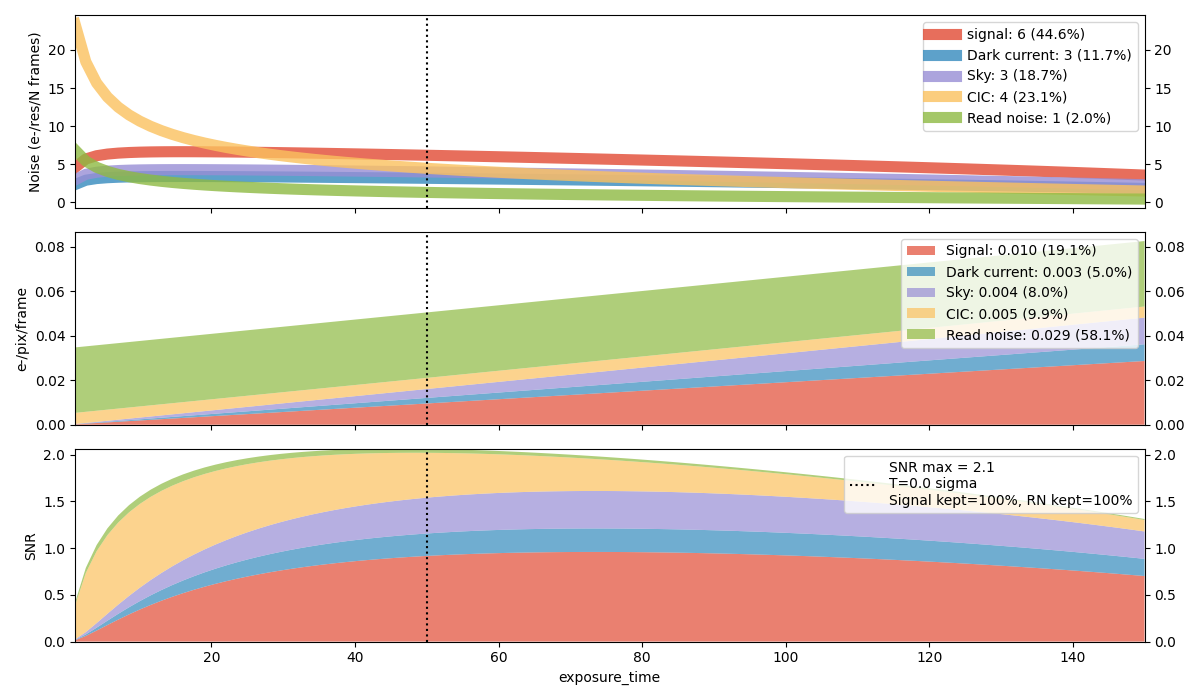

In [3]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
%matplotlib widget
from IPython.display import display, clear_output

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect

import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
from scipy.sparse import dia_matrix
# plt.style.use('dark_background')
def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    names, varargs, keywords, defaults = inspect.getargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper

#fixed parameters
QE = 0.55
resolution_element=57#microns
pixel_size = 13#microns
# Gain_ADU = 0.53 #e-/e-
Throughput = 0.13
Atmosphere = 0.5
colors = ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']

def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    """Creates variable smearing kernels for inversion
    """
    import numpy as np
    
    smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    smearing_kernels = np.exp(-np.arange(6)[:, np.newaxis, np.newaxis] / smearing_length)
    smearing_kernels /= smearing_kernels.sum(axis=0)
    return smearing_kernels   


class Observation:
    @initializer
    def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0,acquisition_time = 2,smearing=0,i=0,plot_=False):#,photon_kept=0.7
        self.ENF = 2 if counting_mode else 1
        self.CIC_noise = np.sqrt(CIC_charge) if counting_mode else np.sqrt(CIC_charge*2)
        self.Dark_current_f = Dard_current * exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f) if counting_mode else np.sqrt(self.Dark_current_f*2)
        
        self.lu2ergs = 2.33E-19/1000        
        self.Sky_ = Sky_LU*self.lu2ergs#/1000*2.33E-19 # ergs/cm2/s/arcsec^2 
        
        if counting_mode:
            #for now we put the regular QE without taking into account the photon fraciton, because then infinite loop
            self.factor_el = QE * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
            self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame
            self.Sky_f =  self.sky * EM_gain #* Gain_ADU  # el/pix/frame
            self.Sky_noise_pre_thresholding = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
            #self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
            #self.Signal_el = self.Signal_LU*self.factor_el*exposure_time 

            #             self.Photon_count_loss = 0.7 if readout_time==1.5 else 0.8 #a contraindre...
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
        else:
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept, self.gain_thresholding = 0,1,1, 0

        self.cosmic_ray_loss = np.minimum(0.005*(exposure_time+readout_time/2),1)
        self.QE_efficiency = self.Photon_fraction_kept * QE#* (1-cosmic_ray_loss)#ne devrait pas etre la 
        
        #for now we put the regular QE without taking into account the photon fraciton, because then infinite loop
        self.factor_el = self.QE_efficiency * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
        self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame
        self.Sky_f =  self.sky * EM_gain #* Gain_ADU  # ADU/pix/frame
        self.Sky_noise = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
            

        #self.RN_fraction_kept = 0.05 if counting_mode else 1
        self.RN_final = RN  * self.RN_fraction_kept / EM_gain #Are we sure about that? we should a
 

        self.Additional_background = Additional_background_2018 * exposure_time *(1-flight_background_damping) # e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background) if counting_mode else np.sqrt(self.Additional_background*2)



        
        
        self.N_images = acquisition_time*3600/(exposure_time+readout_time)
        coeff_stack = 1 #TBC, why was it set to 2
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (resolution_element/pixel_size)**2# el/N exposure/resol
        self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el = self.Signal_LU*self.factor_el*exposure_time  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
        # print(Signal )
        # print(self.Signal_LU )
        # print(self.Signal_el )
#         if counting_mode:
#             print('%0.1f < ExpTime < %0.1f' %(0.01/self.factor_el/self.Signal_LU,0.1/self.factor_el/self.Signal_LU))
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (resolution_element/pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el) if counting_mode else np.sqrt(self.Signal_el*2)     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *resolution_element/pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (resolution_element/pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (resolution_element/pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        if type(self.Total_noise_final + self.Signal_resolution) == np.float64:#to correct
            n=0
        else:
            n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution","Signal_el","sky","CIC_charge","Dark_current_f","RN"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        # self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T

        # self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  0*self.Additional_background_noise, self.sky, self.CIC_charge, self.RN_final]).T
        self.electrons_per_pix =  np.array([self.Signal_el,  self.Dark_current_f,  self.sky, self.CIC_charge, self.RN_final]).T

        self.snrs=self.Signal_resolution /self.Total_noise_final
        if np.ndim(self.noises)==2:
            self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        else:
            self.percents =  100* np.array(self.noises).T[:-1]**2/self.Total_noise_final**2            
        self.el_per_pix = self.Signal_el + self.sky + CIC_charge +  self.Dark_current_f

        # self.percents =  100* np.array(self.noises).T**2/self.Total_noise_final**2
       

    def PlotNoise(self,title='',x='exposure_time'):
        # plt.style.use('seaborn')
        lw=8
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
        # fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(9, 5.5), sharex=True)        # print(self.i)
        for i,(name,c) in enumerate(zip(["signal","Dark current","Sky", "CIC", "Read noise"],colors)):#, "Add. background"
            # ax1.plot(getattr(self,x), getattr(self,name)*self.factor,label='%s: %i (%0.1f%%)'%(name,(getattr(self,name)*self.factor)[np.argmax(self.snrs)],self.percents[i,np.argmax(self.snrs)]),lw=lw,alpha=0.7,c=c)
            # ax1.plot(getattr(self,x), getattr(self,name)*self.factor,label='%s: %i (%0.1f%%)'%(name,(getattr(self,name)*self.factor)[self.i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)
            ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)

        # ax1.plot(getattr(self,x), getattr(self,"Total_noise_final")*self.factor,label="Total_noise_final", lw=lw,alpha=0.7,c='k')
        ax1.legend(loc='upper right')
        # ax3.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,np.max(self.snrs)],':',c='k')
        # ax2.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,100],':',c='k')
        # ax3.plot(getattr(self,x), self.snrs,lw=0,c='k',label='$SNR_{max}$=%0.1f at t=%i'%(np.max(self.snrs),getattr(self,x)[np.argmax(self.snrs)]))
        # ax3.legend(loc='upper right')
        ax1.grid(False)
#         ax1.set_yscale('log')
        ax2.grid(False)
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=colors)
        
        # ax2.stackplot(getattr(self,x),self.percents,alpha=0.7,colors=colors)
        # ax2.set_ylim((0,99.99))
        # ax2.set_ylabel('Noise contribution %')
        # if self.counting_mode:
        #     ax2.stackplot(getattr(self,x),  np.array(self.ADU_per_pix).T[:,:],alpha=0.7,colors=colors)
        #     ax2.set_ylabel('ADU/pix %')
        # else:
        # labels = ['%s: %0.3f (%0.1f%%)'%(name,(getattr(self,"electrons_per_pix")[j])[self.i],1) for j,name in enumerate(["Signal_el","Dark_current_f", "Additional_background_noise","sky", "CIC_charge", "RN_final"])]
        labels = ['%s: %0.3f (%0.1f%%)'%(name,getattr(self,"electrons_per_pix")[self.i,j],100*getattr(self,"electrons_per_pix")[self.i,j]/np.sum(getattr(self,'electrons_per_pix')[self.i,:])) for j,name in enumerate(["Signal","Dark current", "Sky", "CIC", "Read noise"])]#"Add. background",
        ax2.stackplot(getattr(self,x),  np.array(self.electrons_per_pix).T[:,:],alpha=0.7,colors=colors,labels=labels)
        ax2.set_ylabel('e-/pix/frame')
        ax2.legend(loc='upper right')
            # ax2.set_yscale('log')
        # ax2.set_ylim((0,99.99))
# Signal_el,  self.Dark_current_f,  0*self.Additional_background_noise, self.sky, self.CIC_charge, self.RN_final
            # Here we put the number of e- or ADU per pixels? both are interesting as only ADU gives the readnoise contrib.but its in e- that we know if thrsholding if efficient. So could be in e- and when we hit thresholding we put ADU.

        
        # stackplot(time,  np.array(self.noises)[:,-1]**2 /np.array(self.noises).T[:1,:]**2)
        ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))
        ax3.set_ylim((0,np.max(self.SNR)))
        # ax1.set_ylim((time.min(),time.max()))
        ax3.set_xlabel(x)
        ax3.set_ylabel('SNR')
        ax1.set_ylabel('Noise (e-/res/N frames)')
        ax1.tick_params(labelright=True,right=True)
        ax2.tick_params(labelright=True,right=True)
        ax3.tick_params(labelright=True,right=True)
        # ax1.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # fig.suptitle('pompo,')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.EM_gain,self.counting_mode))
        fig.tight_layout()
        return fig 

    
    def compute_optimal_threshold(self,flux = 0.1,dark_cic_sky_noise=None,plot_=False,title='',i=0):
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain if np.isscalar(self.EM_gain) else self.EM_gain[i]#1000
        RN= self.RN if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        size= (int(1e3),int(1e3))
        im = np.random.poisson(flux, size=size)
        values,bins = np.histogram(im,bins=[-0.5,0.5,1.5,2.5])
        ConversionGain=1#/4.5
        imaADU = np.random.gamma(im, Emgain) *ConversionGain
        bins = np.arange(np.min(imaADU)-5*RN*ConversionGain,np.max(imaADU)+5*RN*ConversionGain,25)
        # bins = np.linspace(-500,10000,400)
        #imaADU = (np.random.gamma(im, Emgain) + np.random.normal(0, RN, size=size))*ConversionGain
        if plot_:
            fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(9,5))
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k',label='Before ampl & smearing')
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')


        if self.smearing > 0:
            # print(SmearExpDecrement)
            smearing_kernels = variable_smearing_kernels(
                imaADU, self.smearing, SmearExpDecrement=5e4)
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size))

            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        imaADU += np.random.normal(0, RN, size=size)*ConversionGain
        if plot_:
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='0',log=True)
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='1',log=True)
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='2',log=True)
            ax1.hist(imaADU.flatten(),bins=bins,label='Total histogram',log=True,histtype='step',lw=1,color='k')
        else:
            val0,_ = np.histogram(imaADU[im==0],bins=bins)#,alpha=0.5,label='0',log=True)
            val1,_ = np.histogram(imaADU[im==1],bins=bins)#,alpha=0.5,label='1',log=True)
            val2,_ = np.histogram(imaADU[im==2],bins=bins)#,alpha=0.5,label='2',log=True)

        b = (bins[:-1]+bins[1:])/2
        rn_noise = (RN/(Emgain * ConversionGain)) * np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        signal12 = flux * np.array([np.sum(val1[b>bi])+np.sum(val2[b>bi]) for bi in b])/(np.sum(val1)+np.sum(val2))
        signal1 = flux * np.array([np.sum(val1[b>bi]) for bi in b])/np.sum(val1)

        pc =  ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))
       # pc =  ([np.sum(val0[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))

        if dark_cic_sky_noise is None:
            noise = CIC_noise**2+dark_noise**2+Sky_noise**2
        else:
            noise = dark_cic_sky_noise
        # print('noises = ',noise)
        SNR1 = pc*signal1/np.sqrt(signal1+noise+np.array(rn_noise)**2)
        SNR12 = pc*signal12/ np.sqrt(signal12+noise+np.array(rn_noise)**2)
        SNR_analogic = flux/np.sqrt(2*flux+2*noise+(RN/(Emgain * ConversionGain))**2)
        # print('SNR_analogic = ',SNR_analogic)
        
        threshold = b[np.nanargmax(SNR1)]
        fraction_signal = np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)
        fraction_rn = np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0)
        lw=3
        if plot_:
            ax2.plot(b,signal1,label='Signal(Signal>T)',lw=lw)
            ax2.plot(b,np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0),label='(RN(RN>T)',lw=lw)
            # ax2.plot(b,np.array(rn_noise)**2,label='(RN(RN>T)/EMGAIN)**2',lw=lw)
            ax2.plot(b,pc,label='Fraction(T) of true positive',lw=lw)
            #ax2.plot(b,SNR1/pc,label='SNR without fraction')



            ax2.plot(b,SNR1,label='SNR, frac(N0)=%i%%, frac(N1)=%i%%'%(100*np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0),100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)),lw=lw)
            ax2.plot(b,SNR12,':',label='SFR2, [N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))),lw=lw)
            ax2.plot(b,SNR1/SNR_analogic,label='SNR1 PC / SNR analogic',lw=lw)
            ax2.plot(b,SNR12/SNR_analogic,':',label='SNR12 PC / SNR analogic',lw=lw)
            # ax2.set_yscale('log')
            ax2.set_ylim(ymin=1e-5)
            
            # ax2.plot(b,SNR1,label='[N1]/[N0] = %0.2f, frac(N1)=%i%%'%(val1[np.nanargmax(SNR1)]/val0[np.nanargmax(SNR1)],100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))
            # ax2.plot(b,SNR12,label='[N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))))

            L = ax1.legend(fontsize=10)
            ax2.legend(fontsize=10)
            ax2.set_xlabel('ADU')
            ax1.set_ylabel('#')
            ax2.set_ylabel('SNR')
            threshold = b[np.nanargmax(SNR1)]
            L.get_texts()[1].set_text('0 e- : %i%%, faction kept: %0.2f%%'%(100*values[0]/(size[0]*size[1]),100*np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0)))
            L.get_texts()[2].set_text('1 e- : %i%%, faction kept: %0.2f%%'%(100*values[1]/(size[0]*size[1]),100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))
            L.get_texts()[3].set_text('2 e- : %i%%, faction kept: %0.2f%%'%(100*values[2]/(size[0]*size[1]),100*np.sum(val2[np.nanargmax(SNR1):])/np.sum(val2)))
            ax1.plot([threshold,threshold],[0,np.max(val0)],':',c='k')
            ax2.plot([threshold,threshold],[0,np.nanmax(SNR1)],':',c='k')
            ax1.set_title(title+'Gain = %i, RN = %i, flux = %0.2f, Smearing=%0.1f, Threshold = %i = %0.2f$\sigma$'%(Emgain,RN,flux,self.smearing, threshold,threshold/(RN*ConversionGain)))
            ax1.set_xlim(xmin=bins.min(),xmax=7000)#bins.max())
            fig.tight_layout()

        #print(i)
        #print('flux, threshold,fractions = ',flux,threshold, fraction_signal, fraction_rn)
        #print('RN, Sky_noise, Emgain, CIC_noise: ', RN, Sky_noise, Emgain, CIC_noise)
        return threshold/(RN*ConversionGain), fraction_signal, fraction_rn, np.nanmax(SNR1/SNR_analogic)
 


   

np.seterr(invalid='ignore')
class ExposureTimeCalulator(widgets.HBox):
     
    def __init__(self, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,Additional_background_2018=0):
        super().__init__()
        self.output = widgets.Output()
        self.Additional_background_2018=Additional_background_2018
        time=np.linspace(1,150,100)
        i = np.argmin(abs(time - exposure_time))
        Nominal = Observation(exposure_time=time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,Additional_background_2018=self.Additional_background_2018,smearing=smearing,i=i)#,photon_kept=photon_kept
        #flight_background_damping = 0.9, Additional_background_2018 = 0.0007
        self.x = Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
        self.fig  = Nominal.PlotNoise()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        self.v=[]
        for i, ax in enumerate(self.fig.axes):
            if i==2:
                label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(Nominal.SNR.max(),Nominal.n_threshold, 100*Nominal.Photon_fraction_kept, 100*Nominal.RN_fraction_kept)
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
            else:
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
        ax.legend(loc='upper right')
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]
    
        self.fig.canvas.toolbar_position = 'bottom'
        style={}#{'description_width': 'initial'} 
        width = '400px'
        self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)')#'$t_{exp}$ (s)')
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)')#'$t_{aq}$ (h)')
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)')
#         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 2.22e-14), ('Extremely Bright QSO (mU~15)', 5.08e-15), ('Bright QSO (mU~19.5)', 3.51e-16),('Bright galaxy (mU~22.5)', 2.22e-17), ('Regular galaxy (mU~24)', 5.57e-18), ('Low SB galaxy (mU~25)', 2.2e-18), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux')
        self.EM_gain = widgets.IntSlider( min=200, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain')
        self.RN = widgets.IntSlider( min=30, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise')
        self.CIC_charge = widgets.FloatSlider( min=0.003, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f')#$_{charge}$
        self.Dard_current = widgets.FloatSlider( min=0.01, max=0.3,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f')#$_{current}$
        self.readout_time = widgets.FloatSlider( min=1.5, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1)#$_{time}$
        self.x_axis=widgets.Dropdown(options=['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time"],value=x_axis,description='X axis')#,"smearing"
#         self.mode=widgets.Dropdown(options=['Flight 2018','Nominal 2022 10MHz','Nominal 2022 100MHz'],value='Nominal 2022 10MHz',description='X axis')
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='Thresholding photon counting',disabled=False)#,indent=False)
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
        self.smearing.layout.visibility = 'hidden'
    


        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) ] )
        display(HBox([self.output,controls]))


        


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing):
        """Draw line in plot"""
        with self.output:
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
#             self.fig.suptitle('pompo,')
            # self.ax0.set_title('Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix),y=0.97)
            title = 'Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU)
            value = locals_[x_axis]
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(1,150,100)
            if x_axis == 'Sky_LU':
                Sky_LU=np.logspace(3,7,100)
                
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(1,150)
            if x_axis == 'Signal':
                Signal=np.logspace(-18,-15)
            if x_axis == 'EM_gain':
                EM_gain=np.linspace(200,3000)
            if x_axis == 'acquisition_time':
                acquisition_time=np.linspace(0.1,6)
            if x_axis == 'RN':
                RN=np.linspace(30,120,100)
            elif x_axis == 'CIC_charge':
                CIC_charge=np.linspace( 0.001, 0.1)
            if x_axis == 'Dard_current':
                Dard_current=np.linspace(0.001,1)
            if x_axis == 'readout_time':
                readout_time=np.linspace(0, 50)
            if x_axis == 'smearing':
                smearing=np.linspace(0, 2)

            if (x_axis == 'Sky_LU') | (x_axis == 'Signal') | (x_axis == 'CIC_charge') | (x_axis == 'Dard_current'):
                self.ax0.set_xscale('log')
#                 self.ax2.set_yscale('log')
            else:
                self.ax0.set_xscale('linear')
#                 self.ax2.set_yscale('linear')
            if counting_mode:
                self.smearing.layout.visibility = 'visible'
            else:
                self.smearing.layout.visibility = 'hidden'
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            new_value = locals_[x_axis]
            arg = np.argmin(abs(new_value - value))
            # print('argi = ',value,arg)
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,Additional_background_2018=self.Additional_background_2018,i=arg)
            self.ax0.set_title(title + ", e-/pix=%0.2E"%(new.el_per_pix[arg]),y=0.97)
            for v in self.v:
                v.set_xdata([value,value])
            arg = np.argmin(abs(getattr(new,x_axis) - value))
            # print('arg = ',arg)
            label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%\nThresholding gain=%0.2f'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept, new.gain_thresholding)
            self.v[-1].set_label(label)
            max_,min_=[],[]
            # for i,name in enumerate(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"]):
            for i,name in enumerate(["Signal","Dark current","Sky", "CIC", "Read noise"]): #, "Add. background"
                self.fig.axes[0].lines[i].set_xdata(getattr(new,x_axis))
                # self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
                self.fig.axes[0].lines[i].set_ydata(new.noises[:,i])
                max_.append(np.nanmax(new.noises[:,i]))
                min_.append(np.nanmin(new.noises[:,i]))
                            # ax1.plot(getattr(self,x), self.noises[:,i],label='%s: %i (%0.1f%%)'%(name,self.noises[self.i,i],self.percents[i,self.i]),lw=lw,alpha=0.8,c=c)

                self.fig.axes[0].lines[i].set_label('%s: %i (%0.1f%%)'%(name,new.noises[new.i,i],new.percents[i,new.i]))
                # self.fig.axes[0].lines[i].set_label('%s: %i (%0.1f%%)'%(name,(getattr(new,name)*new.factor)[arg],new.percents[i,arg]))

            self.ax0.set_ylim((-0.5,np.max(max_)))
            self.ax2.legend(loc='upper right')
            self.fig.axes[0].legend(loc='upper right')
            self.fig.axes[2].collections.clear()#cla()#
            self.fig.axes[2].stackplot(getattr(new,x_axis),new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=colors)
            
            
            self.fig.axes[1].collections.clear()#cla()#
            labels = ['%s: %0.3f (%0.1f%%)'%(name,getattr(new,"electrons_per_pix")[new.i,j],100*getattr(new,"electrons_per_pix")[new.i,j]/np.sum(getattr(new,'electrons_per_pix')[new.i,:])) for j,name in enumerate(["Signal","Dark current","Sky", "CIC", "Read noise"])]#, "Add. background"

            self.fig.axes[1].stackplot(getattr(new,x_axis),  np.array(new.electrons_per_pix).T,alpha=0.7,colors=colors,labels=labels)
            self.fig.axes[1].legend(loc='upper right')
            self.fig.axes[1].set_ylim((0,np.max(np.sum(getattr(new,'electrons_per_pix'),axis=1))))
            self.ax2.set_xlabel(x_axis)
            self.ax2.set_xlim((np.min(getattr(new,x_axis)),np.max(getattr(new,x_axis))))
            self.ax2.set_ylim((0,np.max(getattr(new,'SNR'))))


            
# Nominal = Observation(exposure_time=np.linspace(1,150),EM_gain=1500, RN=50,smearing=0.8,counting_mode=False).PlotNoise()#compute_optimal_threshold(plot_=True)#1.5)#2022
# Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1500, RN=50,smearing=0.5,counting_mode=True).compute_optimal_threshold(flux=0.1,plot_=True)#1.5)#2022
# Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1000, RN=50,smearing=0,counting_mode=True).compute_optimal_threshold(flux=0.01,plot_=True)#1.5)#2022

ETC = ExposureTimeCalulator(EM_gain=1700,RN=50, smearing=0.8,Dard_current=0.18,x_axis='exposure_time',counting_mode=False)


# Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=50,smearing=0.5,counting_mode=True).compute_optimal_threshold(flux=0.1,plot_=True)#1.5)#2022
# Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=50,smearing=0.5,counting_mode=True).compute_optimal_threshold(flux=1,plot_=True)#1.5)#2022




# <center>FIREBall-2 SNR calculator </center>

### Explanation
- Gives the estimated signal-to-noise ratio for an extended source on a resolution element
- **Variables:** Source's flux, sky, aquisition time, exposure time, EM gain, dark current, CIC, readnoise, readout time, thresholding and smearing exponential length
- **Fixed Values:** QE = 55%, resolution element=57 mu, pixel_size = 13 mu, throughput = 13%, atmosphere transmission = 50%
- **Outputs:** The noise of the different sources (Signal, Dark, Sky, CIC, RN) is given in e- per resolution element per N frames on the total acquisition time. We give the relative fraction of all sources of noise and the resulting SNR. When thresholding is applied, the smearing can be changed as it will impact the position of the threshold that optimizes the SNR. For this optimal threshold, the fraction of signal and readnoise kept (above the threshold) is given.
- **Caution:** When thresholding photon counting is checked, the optimal threshold is only computed for the given variables, not for the entire range of x_axis values. To see the impact of thresholding you need to move manually the different sliders.

### Analysis
- **Smearing:** At the low temperature we use the EMCCD, the low CTE smears the pixels' counts and then lowers the effective gain. This lowering factor is huge (>2) for a smnearing length of 1.5, but is much smaller for a smearing length of 0.7 (~1.2). 
It seems that we already had a comparabale 0.7 smearing length with previous controller at 10MHz (tests February 7th and 8th 2019) at same EMgain (1600) and temperature (-95C). Which might mean that the 1MHz reading does not decrease significantly the smearing. **With the current (2022) smearing length, thresholding does not increase the SNR!!! If we manage to invert the smearing, even if it doubles the readnoise, we can recover most of the thresholding efficiency.**
- **Photon-counting:** The thresholding effect can be misleading as it depends on Flux, EMgain, RN, smearing and noise($\sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$). But actually it depends mostly on the ratio $\frac{G_{EM,eff}}{RN}$. For a ratio >> 10 the thresholding is efficient. As stated above for a smearing length of 0.7, EMgain and effective_gain are close. A consequence of that, is that at the EMgains we use ($\sim1600$) and smearing $\sim 0.7$, the thresholding is almost as efficient with RN=50 and RN=107 as the ratio $\frac{G_{EM,eff}}{RN}$ stays >>10. This was not the case in 2018 when the smearing length was 1.5. This is why in photon counting mode, you will see a very small impact of read noise change.
- **Reading frequency tradeoff:** Based on above, the change from 10MHz to 1MHz as minor consequences on the total SNR.
    - In photon counting mode and with low smearing, the decrease of the RN has quasi no effect (~1%) on the SNR
    - The transition from 1.4 to 3sec readout would mean a loss of SNR of ~2%, transition to 10sec about ~10% 
    - Therefore the real critical point is the need to add or not a shutter above the tank with the 1MHz controller as it will complexify guidance
- **Temperature Tradeoff:** Based on the 2019 and 2022 images the consequences of a 20 degrees increase is important. With the first approximations, the increase of the dark current combined with the decreae of the smearing length might lead to a 5% SNR increase in counting mode (+sharper PSF). Though, for now, the major consequence of the temperature increase seems to be the high fraction of cosmetics on the lower part of the image. A significant fraction could be corrected for with appropriated software but the fraction can become extremely high and prevent good correction (needs further implementation). This is not taken into account in this model. Decreasing the tempetrature to -100C (TBD) might be a good trade off (in 2019 we had 0.8 smearing at -95C and EMgain=1600).
 
|               **Parameters**           | **2022 1Mhz controller** |  **Values 2018** |
|:--------------------------------------:|:------------------------:|:----------------:|
|       **Temperature (C)**              |          -90             |       -115       |
|       **Conversion gain ADU/e-**       |          1/4.5           |       0.53       |
|            **Read noise e-**           |      50  ( -> 35  ?)     |        107       |
|         **pCIC e− /pix/frame**         |          0.003           | 0.004            |
|         **sCIC e− /pix/frame**         |          ~0.002          |~0.002            |
| **semi-amplified CIC e− /pix/frame**   |          ~0.02           |       ~0.03-4    |
|           **EM gain  e-/e-**           |           1600           |       1400       |
|    **Smearing exponent. length pix**   |     L~0.6 ± 0.1  pix     |    L~1.5 ± 0.1   |
|       **Dark current e− /pix/h**       |          < 0.18          |   0.08 ± 0.03    |
| **Cosmetics % pixels bottom detector** |           ~2%            |    <<1% (TBD)    |
| **Exposure time sec**                  |          50              |    50            |
| **Readout time sec** |~10 (all), ~3(physical) +2 better clearance |    ~1.4          |


<!-- 
### Need to add
- Predictions for point source, sources on several resolution element, stack of galaxies
 -->



In [4]:
# from astropy.io import fits
# from tqdm import tqdm
# n=6
# gains=np.linspace(800,2500,n)
# rons=np.linspace(30,120,n)
# fluxes=np.linspace(0.01,0.7,n)
# smearings=np.linspace(0,2,n)
# print()

# print(gains,rons,fluxes,smearings)
# #normally I should also make evolve 

# threshold2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# fraction_flux2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# fraction_gain2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# snrs_2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))

# gi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# ri = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# fi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# si = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))


# for i in tqdm(range(len(gains))):
#     for j  in tqdm(range(len(rons))):
#         for k in range(len(fluxes)):
#             for l in range(len(smearings)):
#                 t,f1,f2,snr = Observation(exposure_time=np.array([50,50]), EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).compute_optimal_threshold(flux=fluxes[k],plot_=False)#1.5)#2022
#                 # print(i, gain, ron, flux, smearing,f1)
#                 threshold2[i,j,k,l] = t
#                 fraction_flux2[i,j,k,l] = f1
#                 fraction_gain2[i,j,k,l] = f2    
#                 snrs_2[i,j,k,l] = snr    

#                 gi[i,j,k,l] = gains[i]
#                 ri[i,j,k,l] = rons[j]
#                 fi[i,j,k,l] = fluxes[k]
#                 si[i,j,k,l] = smearings[l]
# fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('threshold_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('fraction_flux_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('fraction_rn_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(snrs_2)]).writeto('snr_max_%i.fits'%(n),overwrite=True)

In [5]:
# from astropy.io import fits
# from tqdm import tqdm
# n=5
# gains=np.linspace(800,2500,n)
# rons=np.linspace(30,120,n)
# fluxes=np.linspace(0.01,0.7,n)
# smearings=np.linspace(0,2,n)
# noise=np.linspace(0.002,0.05,n)
# print()

# print(gains,rons,fluxes,smearings)
# #normally I should also make evolve 

# threshold2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# fraction_flux2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# fraction_gain2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# snrs_2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))

# gi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# ri = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# fi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# si = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))


# for i in tqdm(range(len(gains))):
#     for j  in tqdm(range(len(rons))):
#         for k in range(len(fluxes)):
#             for l in range(len(smearings)):
#                 for m in range(len(noise)):
#                     t,f1,f2,snr = Observation(exposure_time=np.array([50,50]), EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).compute_optimal_threshold(flux=fluxes[k],dark_cic_sky_noise=noise[m],plot_=False)#1.5)#2022
#                     # print(i, gain, ron, flux, smearing,f1)
#                     threshold2[i,j,k,l,m] = t
#                     fraction_flux2[i,j,k,l,m] = f1
#                     fraction_gain2[i,j,k,l,m] = f2    
#                     snrs_2[i,j,k,l,m] = snr    
#                     # gi[i,j,k,l,m] = gains[i]
#                     # ri[i,j,k,l,m] = rons[j]
#                     # fi[i,j,k,l,m] = fluxes[k]
#                     # si[i,j,k,l,m] = smearings[l]
# fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('threshold_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('fraction_flux_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('fraction_rn_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(snrs_2)]).writeto('snr_max_%i.fits'%(n),overwrite=True)

Analize_thresholding()

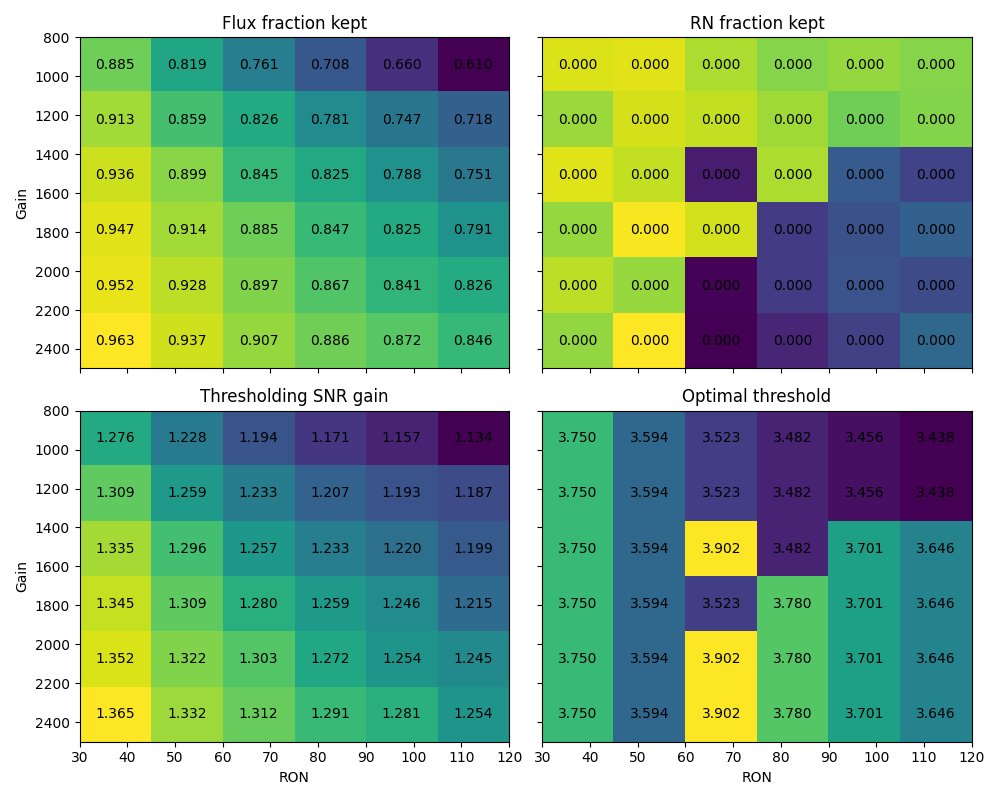

In [6]:
# import matplotlib.pyplot as plt
from astropy.io import fits

class Analize_thresholding(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        self.output = widgets.Output()
        values = [0,1,2,3]
        values.remove(1)
        values.remove(0)
        self.n=6
        gains=np.round(np.linspace(800,2500,self.n),4)
        rons=np.round(np.linspace(30,120,self.n),4)
        fluxes=np.round(np.linspace(0.01,0.3,self.n),4)
        smearings=np.round(np.linspace(0,2,self.n),4)
        # noise=np.round(np.linspace(0.002,0.05,n),4)
        # gains=np. linspace(800,2500,n)
        # rons=np.linspace(30,120,n)
        # fluxes=np. linspace(0.01,1.51,m)
        # smearings=np. linspace(0,2,n)
        i=0
        self.threshold = fits.open('threshold_%i.fits'%(self.n))[0].data
        self.fraction_flux = fits.open('fraction_flux_%i.fits'%(self.n))[0].data
        self.fraction_rn = fits.open('fraction_rn_%i.fits'%(self.n))[0].data
        self.snrs = fits.open('snr_max_%i.fits'%(self.n))[0].data
        # self.snrs /= self.snrs.max()
        # popt,pcov = curve_fit(fourDpolynomy_6,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
        # res_fract_flux =  fourDpolynomy_6((gi,ri,fi,si),*popt)
        value=2
        image_threshold = self.threshold.take(0,axis=value).take(0,axis=value)
        image_fraction_flux = self.fraction_flux.take(0,axis=value).take(0,axis=value)
        image_fraction_rn = self.fraction_rn.take(0,axis=value).take(0,axis=value)
        image_snr = self.snrs.take(0,axis=value).take(0,axis=value)
        self.options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3)]
        self.names =[['Gain',gains],['RON',rons], ['Flux',fluxes],['Smearing',smearings]]
        
        x,y=0,1
        self.fig,self.axes  = plt.subplots(2,2,sharey=True,sharex='col',figsize=(10,8))
        for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','Thresholding SNR gain','Optimal threshold']):
            # print(i)
            ax.clear()
            ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
        # im = ax.imshow(image, extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
        # im = ax.imshow(image, extent=[names[x][1].min(),names[x][1].max(),names[y][1].max(),names[y][1].min()], aspect="auto")
        # im = ax.imshow(image, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
            ax.set_title(title)

            for xi in range(im.shape[0]):
                for yi in range(im.shape[1]):    
                    ax.text(1/(self.n*2) + yi/self.n, 1/(self.n*2)+xi/self.n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
        self.axes.flatten()[2].set_xlabel(self.names[y][0])
        self.axes.flatten()[3].set_xlabel(self.names[y][0])
        self.axes.flatten()[0].set_ylabel(self.names[x][0])
        self.axes.flatten()[2].set_ylabel(self.names[x][0])
        self.fig.tight_layout()
        # self.i_w =  widgets.IntSlider( min=0, max=4,value=0,description='i')
        # self.j_w =  widgets.IntSlider( min=0, max=4,value=0,description='j')
        self.i_w =  widgets.SelectionSlider(options=self.names[values[0]][1],description='Flux',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')
        self.j_w =  widgets.SelectionSlider(options=self.names[values[1]][1],description='Smearing',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')        

        self.y_w =  widgets.Dropdown(options=self.options,value=1,description='First axis')
        # options = self.options
        # options.remove((self.y_w.label,self.y_w.index))
        self.x_w =  widgets.Dropdown(options=self.options,value=0,description='Second axis')
        wids = widgets.interactive(self.show_thresholding,i=self.i_w,j=self.j_w,x=self.x_w,y=self.y_w)
        controls = VBox([HBox([self.i_w ,self.y_w  ]),   HBox([ self.j_w,self.x_w ])   ] )
        display(HBox([self.output,controls]))

    def show_thresholding(self,i,j,x,y):
        with self.output:
            values = [0,1,2,3]
            if x==y:
                # print(list(set(values) -set([y])))
                self.x_w.value = list(set(values) -set([y]))[0]
                x=self.x_w.value
            if x>y:
                x,y=y,x
            values.remove(x)
            values.remove(y)
            # image = fraction_flux2.take(i,axis=values[0])#fraction_flux2[]
            i_  = self.i_w.index
            j_  = self.j_w.index

            image_threshold = self.threshold.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_fraction_flux = self.fraction_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_fraction_rn = self.fraction_rn.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_snr = self.snrs.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flu
      # image_res_fraction_rn = res_fract_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            
            self.i_w.description = self.names[values[0]][0]
            self.j_w.description = self.names[values[1]][0]
            self.i_w.options = self.names[values[0]][1]
            self.j_w.options = self.names[values[1]][1]
            
            
            
            for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','Thresholding SNR gain','Optimal threshold']):
                ax.clear()
                ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
                ax.set_title(title)
                for xi in range(im.shape[0]):
                    for yi in range(im.shape[1]):    
                        ax.text(1/(self.n*2) + yi/self.n, 1/(self.n*2)+xi/self.n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
            self.axes.flatten()[2].set_xlabel(self.names[y][0])
            self.axes.flatten()[3].set_xlabel(self.names[y][0])
            self.axes.flatten()[0].set_ylabel(self.names[x][0])
            self.axes.flatten()[2].set_ylabel(self.names[x][0])

Analize_thresholding()
#- why the SNR does not peak at F=0.1e-



## Thresholding analysis
The threshold is computed by optimizing the SNR:

$$ SNR = F_{True,pos}\frac{S}{\sqrt{S + \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2   + \sigma_{RN}^2 }}$$

with:
- $S=Flux  \times \frac{\sum Signal[Signal>T]}{\sum Signal} = Flux  \times \%pix_{e^->0}^{ADU>T}$: the fraction of pixels above the threshold in the ADU distribution which received photo-electrons
- $\sigma_{RN}^2=\frac{RN}{G_{EM,eff}} \times \frac{\sum RN[RN>T]}{\sum RN} = \frac{RN}{EMgain}  \times \%pix_{e^-=0}^{ADU>T}$: the fraction of pixels above the threshold which dit not receive any photo-electrons
- $F_{True,pos} = \frac{\%pix_{e^->0}^{ADU>T}}{\%pix^{ADU>T}} $ : the fraction of true positives = the fraction of pixels above the threshold which received more than 0 photo-electons


The thresholding depends on 5 factors:
- The gain: the higher the gain the easier it is to differentiate pixels who received a photo-electron and those which did not
- The read noise: the lower the RN the easier it is to differentiate pixels who received a photo-electron and those which did not
- The low CTE smears the charges, from pixels who did receive a photo-electron to pixel who did not and lower the effective gain $G_{EM,eff}$
- The signal: because thresholding only allows to recover 0 and 1, thresholding is only efficient at flux <<1e-/exp 
- The additional noise: $\sigma = \sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$ has relatively small impact on the impact of the thresholding

**At the end, the thresholding impact is:**
- Highly non linear, many things to learn
- The efficiency of the thresholding depends mostly of the ratio $\frac{G_{EM,eff}}{RN}$, which extremely impacted by the smearing.
- The thresholding SNR gain (SNR$_{threshold}$/SNR$_{analogic}$) lies within $[0,\sqrt{2}]$. Condditions are pretty stricts to get som thresholding efficiency and smearing makes the upper bound falls dramatically. 
- Therefore if might not worth it to loose SNR in order to be in these very conditions as we will loose it anyway in the final budget.
- The thresholding SNR gain seems less impacted by read noise. Which means that if we manage to do some (linear?) inversion of the smearing which increases the noise, it might still increase the thresholding gain above 1. 
- The only real game changer in terms of SNR is the smearing 
- **Fraction kept (photo-electrons above threshold)**
    - Important dependance on smearing and flux, less important one on gain and read noise.
    - At low smearing the bigger the ratio gain/ron the higher the fraction of charges kept.
    - Evolution with smearing is dramatic, higher gain does not help much, lower RN helps
    - Fraction increase with flux 
- **Fraction fake detections (0e- pixels above threshold)**
    - Increases importantly with smearing
    - does not depend much on read noise (small positive correlation)
    - decreases with gain
    - Increases as Flux increase. Not sure to understand why... Maybe because the number of pixels with 0 photo-e- cecreases 
- **Thresholding SNR gain**
    - Thresholding is efficient only if >1
    - Dramatically decreases with smearing (No interest of thrsholding above smearing legth of 0.6)
    - Increases with gain and decreases with read noise if no smearing
    - if smearing, the read noise has no impact.
    - Increases with flux
- **Threshold**
    - increase extremely with smearing
    - Without smearing, poor dependance on gain and readnoise
    - If smearing, increases as readnoise decreases
    - If smearing: Increasing with gain!
    - Increases with flux




|   **Thresholding dependancy table**                   | **Smearing <br />  ( 0 - 2 )** | **Read noise  <br /> ( 30 - 120 )** | **Gain  <br /> ( 800 - 2500 )** | **Flux <br /> ( 0.01 - 1.5 )** |
|:--------------------:|:------------------:|:-----------------------:|:-------------------:|:------------------:|
|     **Photo-electron Fraction kept**    |    --- <br /> 92% - 66%    |       -  <br /> 72% - 71%       |     .   <br /> 72% - 71%    |     +  <br /> 75% - 76%    |
| **RN fraction kept** |  +++  <br /> 0.6% - 12.4%  |       +  <br /> 0.7% - 1%       |    -  <br /> 1.1% - 0.5%    |    ++?  <br /> 0.3% - 3%   |
|     **Threshold**    |   +++  <br /> 3 σ - 11 σ   |      --  <br /> 18 σ - 5 σ      |     + <br />  5 σ - 16 σ    |    +? <br />  8 σ - 13 σ    |
|        **Thresholding SNR gain**       |     --- <br />  1.3 - 0.6   |        --  <br /> 1.35 - 1.22        |      +  <br /> 1.13 - 1.18      |      ++  <br /> 1.16 - 1.21     |

<!-- |        **SNR**       |     --- <br />  48 - 22    |        .  <br /> 40 - 40        |      +  <br /> 39 - 41      |      ++  <br /> 4 - 83     | -->

In [7]:
import os


# def addAtPos(M1, M2, center):
#     """Add a matrix in a higher dimension matric at a given position
#     """
#     size_x, size_y = np.shape(M2)
#     coor_x, coor_y = center
#     end_x, end_y = (coor_x + size_x), (coor_y + size_y)
#     M1[coor_x:end_x, coor_y:end_y] = M1[coor_x:end_x, coor_y:end_y] + M2
#     return M1

# def createHole(radius=40, size=(200, 200)):
#     """
#     Create a disk of the size specified in arcsec to then be convolved to the PSF :
#     convolution.Gaussian2DKernel
#     """
#     Hole = np.zeros((size[0], size[1]))
#     y, x = np.indices((Hole.shape))
#     r = np.sqrt((x - size[0] / 2) ** 2 + (y - size[1] / 2) ** 2)  #    r = np.around(r)-1
#     r = r.astype(np.int)
#     Hole[r < radius] = 1
#     return Hole

# def convolvePSF(radius_hole=20, fwhmsPSF=[5, 6], unit=10, size=(201, 201), Plot=False):
#     """
#     Convolve a disk from createHole with a gaussian kernel with the specified size in arcsec
#     """
#     from astropy import convolution
#     from astropy.convolution import Gaussian2DKernel

#     PSF = Gaussian2DKernel(x_stddev=fwhmsPSF[0] / 2.35, y_stddev=fwhmsPSF[1] / 2.35, x_size=size[0], y_size=size[1]).array
#     PSF /= PSF.max()
#     Hole = createHole(radius=radius_hole, size=size)
#     conv = convolution.convolve(PSF, Hole)
#     if Plot:
#         plt.plot(conv[:, int(size / 2)] / conv[:, int(size / 2)].max(), "-", label="PSF:" + np.str(fwhmsPSF) + "dec''")
#         plt.plot(Hole[:, int(size / 2)] / Hole[:, int(size / 2)].max(), label="Hole:{}dec''".format(2 * radius_hole))
#         plt.legend(loc="upper right")
#     return conv


def ConvolveSlit2D_PSF(xy=np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)), amp=1, l=3, L=20, xo=0, yo=0, sigmax2=20, sigmay2=20):
    """Convolve a 2D slit with a gaussina
    """
    from scipy import special

    x, y = xy
    A1 = special.erf((l - (x - xo)) / np.sqrt(2 * sigmax2))
    A2 = special.erf((l + (x - xo)) / np.sqrt(2 * sigmax2))
    B1 = special.erf((L - (y - yo)) / np.sqrt(2 * sigmay2))
    B2 = special.erf((L + (y - yo)) / np.sqrt(2 * sigmay2))
    function = (A1 + A2) * (B1 + B2)#amp * (1 / (16 * l * L)) * 
    function *= amp/function.ptp()
    return function.ravel()
def SimulateFIREBallemCCDImage(
#     ConversionGain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=1, p_sCIC=1, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Spectra", Rx=8, Ry=8, size=[3216, 2069], OSregions=[1066, 2124], name="Auto", spectra="-", cube="-", n_registers=604, save=False
    ConversionGain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=0.0005, p_sCIC=0, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Slit", Rx=8, Ry=8, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, sky=0,save=False,stack=1
):

    from astropy.modeling.functional_models import Gaussian2D
    from scipy.sparse import dia_matrix

    OS1, OS2 = OSregions
#     if Bias == "Auto":
#         if EmGain > 1:
#             Bias = 3000 / ConversionGain
#         else:
#             Bias = 6000 / ConversionGain
#     else:
#         Bias = float(Bias) / ConversionGain
    ConversionGain=1
    Bias=0
    image = np.zeros((size[1], size[0]), dtype="float64")

    # dark & flux
    source_im = 0 * image#[:, OSregions[0] : OSregions[1]]
    lx, ly = source_im.shape
    y = np.linspace(0, lx - 1, lx)
    x = np.linspace(0, ly - 1, ly)
    x, y = np.meshgrid(x, y)

    # Source definition. For now the flux is not normalized at all, need to fix this
    # Cubes still needs to be implememted, link to detector model or putting it here?
    if os.path.isfile(cube):
        from .FitsCube import FitsCube

        source_im = FitsCube(filename=cube)
    elif source == "Flat-field":
        source_im += flux
    elif source == "Dirac":
        source_im += Gaussian2D.evaluate(x, y,  flux, ly / 2, lx / 2, Ry, Rx, 0)
    elif source == "Spectra":
        source_im += Gaussian2D.evaluate(x, y, flux, ly / 2, lx / 2, 100 * Ry, Rx, 0)
    elif source == "Slit":
        ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
        source_im += ConvolveSlit2D_PSF_75muWidth((x, y), flux, 9, ly / 2, lx / 2, Rx, Ry).reshape(lx, ly)
    elif source == "Fibre":
        #print("Create fibre source, FWHM: ", 2.353 * Rx, 2.353 * Ry)
        fibre = convolvePSF(radius_hole=10, fwhmsPSF=[2.353 * Rx, 2.353 * Ry], unit=1, size=(201, 201), Plot=False)  # [:,OSregions[0]:OSregions[1]]
        source_im = addAtPos(source_im, fibre, (int(lx / 2), int(ly / 2)))
        #print("Done")
    elif source[:5] == "Field":
        ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
        ws = [2025, 2062, 2139]
        # x, y = [], []
        for i, w in enumerate(ws):
            slits = returnXY(source[0].lower() + source[-1], w=w, frame="observedframe")
            xs = slits[0]
            ys = slits[1]
            index = (ys > OS1) & (ys < OS2)
            #print(xs, ys)
            for yi, xi in zip(np.array(ys[index]) - OS1, xs[index]):
                #print(xi, yi)
                source_im += ConvolveSlit2D_PSF_75muWidth((x, y), flux, 9, yi, xi, Rx, Ry).reshape(lx, ly)

    # Poisson realisation
    source_im = (Dark + source_im + sky) * exposure
    image += np.random.gamma( np.random.poisson(source_im) + np.array(np.random.rand(size[1], size[0])<p_pCIC,dtype=int) , EmGain)
    image_stack = np.mean([np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand(size[1], size[0])<p_pCIC,dtype=int) , EmGain) for i in range(int(stack))],axis=0)
 
    # Addition of the phyical image on the 2 overscan regions
#     image[:, OSregions[0] : OSregions[1]] += source_im2
#     image += source_im2
    image +=  np.random.gamma( np.array(np.random.rand(size[1], size[0])<p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
    image_stack += np.random.gamma( np.array(np.random.rand(size[1], size[0])<int(stack)*p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
 
                           #     if EmGain > 1:

#         # addition of pCIC (stil need to add sCIC before EM registers)
#         prob_pCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
#         image[prob_pCIC < p_pCIC] += 1
#         source_im2_stack[prob_pCIC < p_pCIC*stack] += 1

#         # EM amp (of source + dark + pCIC)
#         id_nnul = image != 0
#         image[id_nnul] = np.random.gamma(image[id_nnul], EmGain)

        # Addition of sCIC inside EM registers (ie partially amplified)
#         prob_sCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
#         id_scic = prob_sCIC < p_sCIC  # sCIC positions
#         # partial amplification of sCIC
#         register = np.random.randint(1, n_registers, size=id_scic.sum())  # Draw at which stage of the EM register the electorn is created
#         image[id_scic] += np.random.exponential(np.power(EmGain, register / n_registers))

    # semaring post EM amp (sgest noise reduction)
    if Smearing > 0:
        # smearing dependant on flux
        smearing_kernels = variable_smearing_kernels(image, Smearing, SmearExpDecrement)
        offsets = np.arange(6)
        A = dia_matrix((smearing_kernels.reshape((6, -1)), offsets), shape=(image.size, image.size))

        image = A.dot(image.ravel()).reshape(image.shape)
        image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)

    # read noise
    readout = np.random.normal(Bias, RN, (size[1], size[0]))
    readout_stack = np.random.normal(Bias, RN/np.sqrt(int(stack)), (size[1], size[0]))

    #print(np.max(((image + readout) * ConversionGain).round()))
#     if np.max(((image + readout) * ConversionGain).round()) > 2 ** 15:
    type_ = "int32"
    type_ = "float64"
#     else:
#         type_ = "int16"
    #print("Flux = %0.3f, gamma scale = %0.1f, RN = %0.1f" % (Dark * exposure, EmGain, RN))
    #print("Saving data in type " + type_)

    imaADU_wo_RN = (image * ConversionGain).round().astype(type_)
    imaADU_RN = (readout * ConversionGain).round().astype(type_)
    imaADU = ((image + readout) * ConversionGain).round().astype(type_)
    imaADU_stack = ((image_stack + readout_stack) * ConversionGain).round().astype(type_)

    # Not sure why now, but several events much higher than 2**16 -> put then to 0 for now...
#     id_null = np.array((image + readout) * ConversionGain, dtype="int16") < 0
#     image[id_null] = 0

    return imaADU, imaADU_stack, source_im#imaADU_wo_RN, imaADU_RN

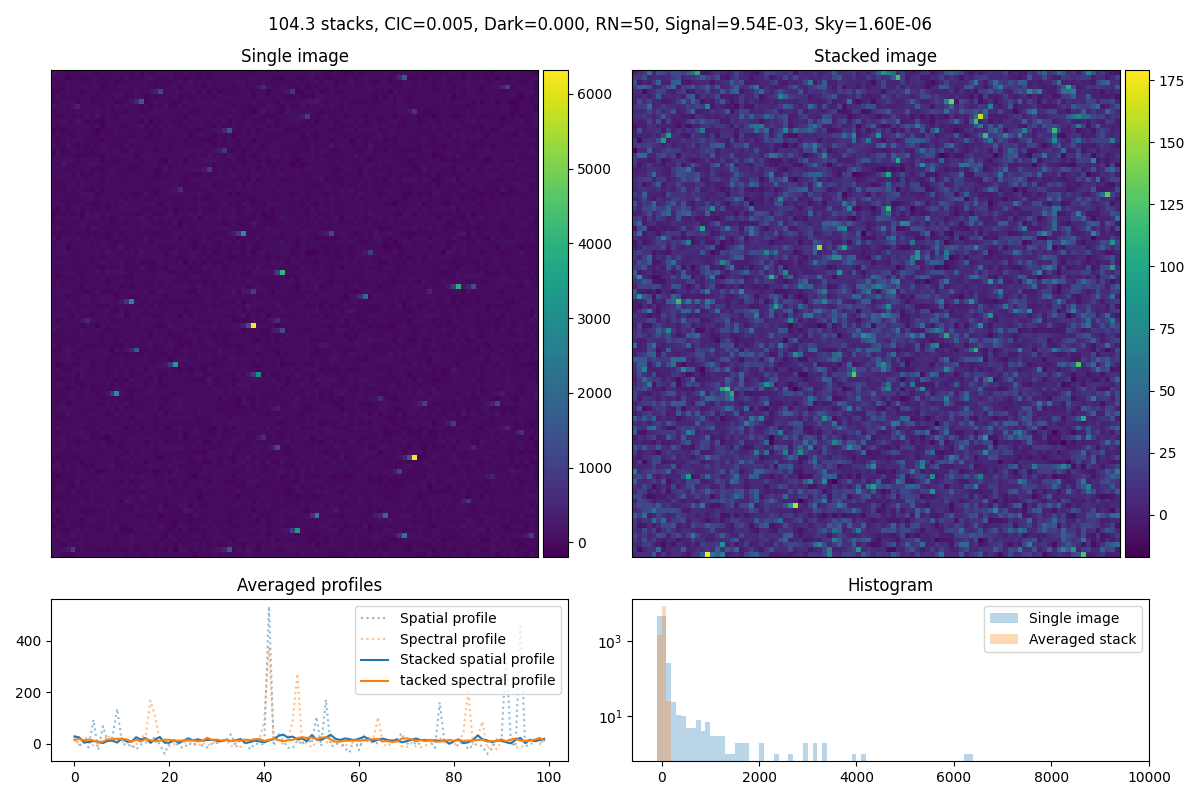

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(invalid='ignore')
class Image(widgets.HBox):
     
    def __init__(self, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='Slit',counting_mode=False,smearing=0.7,Additional_background_2018=0):
        super().__init__()
        self.output = widgets.Output()
        self.Additional_background_2018=Additional_background_2018
        time=np.linspace(1,150,100)
#         i = np.argmin(abs(time - exposure_time))
#         Nominal = Observation(exposure_time=time,counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,Additional_background_2018=self.Additional_background_2018,smearing=smearing,i=i)#,photon_kept=photon_kept
        #flight_background_damping = 0.9, Additional_background_2018 = 0.0007
#         self.x = Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)

        new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,Additional_background_2018=self.Additional_background_2018)#,i=arg)
        self.im,self.im_stack,self.im0 = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=Dard_current/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=new.Signal_el/exposure_time, sky=new.sky/exposure_time, source="Slit", Rx=5, Ry=5, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, save=False,stack=int(new.N_images_true))

#             ConversionGain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=0.0005, p_sCIC=0.0005, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Slit", Rx=8, Ry=8, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, save=False

#         self.im = SimulateFIREBallemCCDImage()[0]
        self.bins=100#np.arange(-100,10000,10)
        self.bins=np.arange(-100,10000,100)
        self.fig, ((self.ax,self.ax0),(self.ax1,self.ax2))  = plt.subplots(2,2,figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})#Nominal.PlotNoise()
        im=self.ax.imshow(self.im, aspect="auto")
        im2=self.ax0.imshow(self.im_stack, aspect="auto")
        self.ax0.get_xaxis().set_ticks([])
        self.ax0.get_yaxis().set_ticks([])
        self.ax.get_xaxis().set_ticks([])
        self.ax.get_yaxis().set_ticks([])
        self.ax.set_title('Single image')
        self.ax0.set_title('Stacked image')
        self.ax1.set_title('Averaged profiles')
        self.ax2.set_title('Histogram')
        self.l1 = self.ax1.plot(self.im[:,45:-45].mean(axis=1),':',label='Spatial profile',alpha=0.5)
        self.l2 = self.ax1.plot(self.im[40:-40,:].mean(axis=0),':',label='Spectral profile',alpha=0.5)
        self.l1_s = self.ax1.plot(self.im_stack[:,45:-45].mean(axis=1),label='Stacked spatial profile',c=self.l1[0].get_color())
        self.l2_s = self.ax1.plot(self.im_stack[40:-40,:].mean(axis=0),label='tacked spectral profile',c=self.l2[0].get_color())
        
        self.ax1.legend(loc='upper right')
        self.ax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
        self.ax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
        self.ax2.legend(loc='upper right')
        self.ax2.set_xlim(xmax=10000)
        self.cax = make_axes_locatable(self.ax).append_axes('right', size='5%', pad=0.05)
        self.cax0 = make_axes_locatable(self.ax0).append_axes('right', size='5%', pad=0.05)
        self.fig.colorbar(im, cax=self.cax, orientation='vertical')
        self.fig.colorbar(im2, cax=self.cax0, orientation='vertical')
        self.fig.canvas.toolbar_position = 'bottom'
        title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge,Dard_current/3600,RN,new.Signal_el,new.sky)

        self.fig.suptitle(title)

        self.fig.tight_layout()
        style={}#{'description_width': 'initial'} 
        width = '400px'
        continuous_update=False
        
        self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)',continuous_update=continuous_update)
        self.acquisition_time = widgets.FloatSlider( min=0.03, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',continuous_update=continuous_update)
        self.Sky_LU = widgets.FloatLogSlider( min=0, max=7,value=Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',continuous_update=continuous_update)
#         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 2.22e-14), ('Extremely Bright QSO (mU~15)', 5.08e-15), ('Bright QSO (mU~19.5)', 3.51e-16),('Bright galaxy (mU~22.5)', 2.22e-17), ('Regular galaxy (mU~24)', 5.57e-18), ('Low SB galaxy (mU~25)', 2.2e-18), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux')
        self.EM_gain = widgets.IntSlider( min=200, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',continuous_update=continuous_update)
        self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update)
        self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update)
        self.Dard_current = widgets.FloatSlider( min=0, max=0.3,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update)
        self.readout_time = widgets.FloatSlider( min=1.5, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update)
        self.x_axis=widgets.Dropdown(options=["Flat-field","Dirac","Spectra","Slit"],value="Slit",description='Field')
#         self.mode=widgets.Dropdown(options=['Flight 2018','Nominal 2022 10MHz','Nominal 2022 100MHz'],value='Nominal 2022 10MHz',description='X axis')
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='Thresholding photon counting',disabled=False)
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')


        
        self.counting_mode.layout.visibility = 'hidden'
        self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
#         self.smearing.layout.visibility = 'hidden'
    


        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) ] )
        display(HBox([self.output,controls]))

        


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing):
        """Draw line in plot"""
        with self.output:
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
#             self.fig.suptitle('pompo,')
#             title='Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU,self.el_per_pix)
#             value = locals_[x_axis]

#             if counting_mode:
#                 self.smearing.layout.visibility = 'visible'
#             else:
#                 self.smearing.layout.visibility = 'hidden'
#             counting_mode=False
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,Additional_background_2018=self.Additional_background_2018)#,i=arg)
            self.im,self.im_stack,self.im0  =  SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=Dard_current/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=new.Signal_el/exposure_time, sky=new.sky/exposure_time, source=x_axis, Rx=5, Ry=5, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, save=False,stack=int(new.N_images_true))
#             im = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias="Auto", RN=RN, p_pCIC=1, p_sCIC=1, Dark=Dard_current, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=Signal, source="Slit", Rx=8, Ry=8, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, save=False)[0]
            im = self.ax.imshow(self.im, aspect="auto")
            im0 = self.ax0.imshow(self.im_stack, aspect="auto")
            self.fig.colorbar(im, cax=self.cax, orientation='vertical')
            self.fig.colorbar(im0, cax=self.cax0, orientation='vertical')

#             self.fig.colorbar(im, cax=self.cax, orientation='vertical')
#             print(self.fig.axes)
            self.fig.axes[2].lines[0].set_ydata(self.im[40:-40,:].mean(axis=0))
            self.fig.axes[2].lines[1].set_ydata(self.im[:,45:-45].mean(axis=1))
            self.fig.axes[2].lines[2].set_ydata(np.mean(self.im_stack[40:-40,:],axis=0))
            self.fig.axes[2].lines[3].set_ydata(np.mean(self.im_stack[:,45:-45],axis=1))

            self.fig.axes[2].relim()
            self.fig.axes[2].autoscale_view()
#             self.fig.axes[2].collections.clear()
            self.fig.axes[3].patches.clear()
            self.fig.axes[3].hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
            self.fig.axes[3].hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
            self.fig.axes[3].legend(loc='upper right')

#             self.fig.canvas.draw()
#             plt.show()
            title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(new.N_images_true,CIC_charge,Dard_current/3600,RN,new.Signal_el,new.sky)
            self.fig.suptitle(title)



ETC = Image(EM_gain=1700,RN=50, smearing=0.8,Dard_current=0.18,x_axis='exposure_time',counting_mode=False)




# <center>Image simulator </center>

### TODO
- Single images should look like what we normally get (with dark/CIC)
- Current estimations do not give enough counts. Are we under-estimating CIC or dark? It might be due to the fact that mCIC is much not taken into account and is much bigger that s/pCIC, eventhough less amplified
- 


In [255]:
# # import matplotlib.pyplot as plt
# from astropy.io import fits

# class Analize_thresholding(widgets.HBox):
     
#     def __init__(self):
#         super().__init__()
#         self.output = widgets.Output()
#         values = [0,1,2,3,4]
#         values.remove(1)
#         values.remove(0)
#         n=5
#         gains=np.round(np.linspace(800,2500,n),4)
#         rons=np.round(np.linspace(30,120,n),4)
#         fluxes=np.round(np.linspace(0.01,0.3,n),4)
#         smearings=np.round(np.linspace(0,2,n),4)
#         noise=np.round(np.linspace(0.002,0.05,n),4)
#         self.options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3),('Noise',4)]
#         self.names =[['Gain',gains],['RON',rons], ['Flux',fluxes],['Smearing',smearings],['Noise',noise]]
#         # gains=np. linspace(800,2500,n)
#         # rons=np.linspace(30,120,n)
#         # fluxes=np. linspace(0.01,1.51,m)
#         # smearings=np. linspace(0,2,n)
#         i=0
#         self.threshold = fits.open('threshold_%i.fits'%(n))[0].data
#         self.fraction_flux = fits.open('fraction_flux_%i.fits'%(n))[0].data
#         self.fraction_rn = fits.open('fraction_rn_%i.fits'%(n))[0].data
#         self.snrs = fits.open('snr_max_%i.fits'%(n))[0].data
        ### self.snrs /= self.snrs.max()
#         # popt,pcov = curve_fit(fourDpolynomy_6,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
#         # res_fract_flux =  fourDpolynomy_6((gi,ri,fi,si),*popt)
#         value=2
#         image_threshold = self.threshold.take(0,axis=value).take(0,axis=value).take(0,axis=value)
#         image_fraction_flux = self.fraction_flux.take(0,axis=value).take(0,axis=value).take(0,axis=value)
#         image_fraction_rn = self.fraction_rn.take(0,axis=value).take(0,axis=value).take(0,axis=value)
#         image_snr = self.snrs.take(0,axis=value).take(0,axis=value).take(0,axis=value)
        
#         x,y=0,1
#         self.fig,self.axes  = plt.subplots(2,2,sharey=True,sharex='col',figsize=(10,8))
#         for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','SNR max','Optimal threshold']):
#             # print(i)
#             ax.clear()
#             ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
#         # im = ax.imshow(image, extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
#         # im = ax.imshow(image, extent=[names[x][1].min(),names[x][1].max(),names[y][1].max(),names[y][1].min()], aspect="auto")
#         # im = ax.imshow(image, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
#             ax.set_title(title)

#             for xi in range(im.shape[0]):
#                 for yi in range(im.shape[1]):    
#                     ax.text(1/(n*2) + yi/n, 1/(n*2)+xi/n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
#         self.axes.flatten()[2].set_xlabel(self.names[y][0])
#         self.axes.flatten()[3].set_xlabel(self.names[y][0])
#         self.axes.flatten()[0].set_ylabel(self.names[x][0])
#         self.axes.flatten()[2].set_ylabel(self.names[x][0])
#         self.fig.tight_layout()
#         # self.i_w =  widgets.IntSlider( min=0, max=4,value=0,description='i')
#         # self.j_w =  widgets.IntSlider( min=0, max=4,value=0,description='j')
#         self.i_w =  widgets.SelectionSlider(options=self.names[values[0]][1],description='Flux',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')
#         self.j_w =  widgets.SelectionSlider(options=self.names[values[1]][1],description='Smearing',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')        
#         self.k_w =  widgets.SelectionSlider(options=self.names[values[2]][1],description='Noise',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')        

#         self.y_w =  widgets.Dropdown(options=self.options,value=1,description='First axis')
#         # options = self.options
#         # options.remove((self.y_w.label,self.y_w.index))
#         self.x_w =  widgets.Dropdown(options=self.options,value=0,description='Second axis')
#         wids = widgets.interactive(self.show_thresholding,i=self.i_w,j=self.j_w,k=self.k_w,x=self.x_w,y=self.y_w)
#         controls = VBox([HBox([self.i_w ,self.y_w  ]),   HBox([ self.j_w,self.x_w ]) ,   HBox([ self.k_w])   ] )
#         display(HBox([self.output,controls]))

#     def show_thresholding(self,i,j,k,x,y):
#         with self.output:
#             values = [0,1,2,3,4]
#             if x==y:
#                 # print(list(set(values) -set([y])))
#                 self.x_w.value = list(set(values) -set([y]))[0]
#                 x=self.x_w.value
#             if x>y:
#                 x,y=y,x
#             values.remove(x)
#             values.remove(y)
#             # image = fraction_flux2.take(i,axis=values[0])#fraction_flux2[]
#             i_  = self.i_w.index
#             j_  = self.j_w.index
#             k_  = self.k_w.index

#             image_threshold = self.threshold.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#             image_fraction_flux = self.fraction_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#             image_fraction_rn = self.fraction_rn.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#             image_snr = self.snrs.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#       # image_res_fraction_rn = res_fract_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            
#             self.i_w.description = self.names[values[0]][0]
#             self.j_w.description = self.names[values[1]][0]
#             self.i_w.options = self.names[values[0]][1]
#             self.j_w.options = self.names[values[1]][1]

#             self.k_w.options = self.names[values[2]][1]
#             self.k_w.description = self.names[values[2]][0]
            
            
#             for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','SNR max','Optimal threshold']):
#                 ax.clear()
#                 ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
#                 ax.set_title(title)
#                 for xi in range(im.shape[0]):
#                     for yi in range(im.shape[1]):    
#                         ax.text(1/(n*2) + yi/n, 1/(n*2)+xi/n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
#             self.axes.flatten()[2].set_xlabel(self.names[y][0])
#             self.axes.flatten()[3].set_xlabel(self.names[y][0])
#             self.axes.flatten()[0].set_ylabel(self.names[x][0])
#             self.axes.flatten()[2].set_ylabel(self.names[x][0])

# Analize_thresholding()
# #- why the SNR does not peak at F=0.1e-
# #we should only show the interest of thresholding (between 0 & 1)

In [5]:
# from ipynb.fs.full.ETC_test import test
#la proporiton de RN kept qui augmente c'est pck le RN total diminue beaucoup vu que le flux augmente...
#Il faut sans doute augmenter le range superieur de l'histogramme car avec plus de flux on va bcp trop loin...


In [6]:

def PlotFit1D(
    x=None,
    y=[709, 1206, 1330],
    deg=1,
    plot_=True,
    sigma_clip=None,
    title=None,
    xlabel=None,
    ylabel=None,
    P0=None,
    bounds=(-1e10, 1e10),
    fmt=".",
    ax=None,
    # c="black",
    Type="normal",
    sigma=None,
    # ls=":",
    interactive=False,
    **kwargs,
):
    """ PlotFit1D(np.arange(100),np.arange(100)**2
    + 1000*np.random.poisson(1,size=100),2)
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from decimal import Decimal
    import numpy as np

    x, y = np.array(x), np.array(y)

    if x is None:
        x = np.arange(len(y))

    if sigma is not None:
        x = x[np.isfinite(y)]
        y = y[np.isfinite(y)]
        sigma = sigma[np.isfinite(y)]
    else:
        x = x[np.isfinite(y)]
        y = y[np.isfinite(y)]

    x = np.array(x)
    y = np.array(y)

    if sigma_clip is not None:
        index = (
            (x > np.nanmean(x) - sigma_clip[0] * np.nanstd(x))
            & (x < np.nanmean(x) + sigma_clip[0] * np.nanstd(x))
            & (y > np.nanmean(y) - sigma_clip[1] * np.nanstd(y))
            & (y < np.nanmean(y) + sigma_clip[1] * np.nanstd(y))
        )
        x, y = x[index], y[index]
        std = np.nanstd(y)
    else:

        sigma_clip = [10, 1]
        index = (
            (x > np.nanmean(x) - sigma_clip[0] * np.nanstd(x))
            & (x < np.nanmean(x) + sigma_clip[0] * np.nanstd(x))
            & (y > np.nanmean(y) - sigma_clip[1] * np.nanstd(y))
            & (y < np.nanmean(y) + sigma_clip[1] * np.nanstd(y))
        )
        std = np.nanstd(y[index])

    if plot_ & (ax is None):
        fig = plt.figure()  # figsize=(10,6))
        gs = gridspec.GridSpec(2, 1, height_ratios=(4, 1))
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        if sigma is None:
            ax1.plot(x, y, fmt, label="Data", **kwargs)
        else:
            ax1.errorbar(x, y, fmt=fmt, yerr=sigma, **kwargs)

    xp = np.linspace(x.min(), x.max(), 1000)

    def linear_func(p, x):
        m, c = p
        return m * x + c

    if type(deg) == int:
        z, res, rank, singular, rcond = np.polyfit(x, y, deg, full=True)
        pcov = None
        popt = np.poly1d(z)
        law = np.poly1d(z)
        if (deg == 1) & (Type == "ortho"):
            import scipy

            linear_model = scipy.odr.Model(linear_func)
            data = scipy.odr.RealData(x, y)
            odr = scipy.odr.ODR(data, linear_model, beta0=[0.0, 1.0])
            out = odr.run()
            popt = np.poly1d(out.beta)
            law = np.poly1d(out.beta)
        zp = popt(xp)
        if P0 is not None:
            z0 = np.poly1d(P0)(xp)
        zz = popt(x)
        degs = [" %0.2f * x^%i" % (a, i) for i, a in enumerate(popt.coef[::-1])]
        # name = "Fit: " + "+".join(degs) + ", R=%0.2E" % (Decimal(res[0]))
    else:
        from scipy.optimize import curve_fit

        if deg == "exp":

            def law(x, b, a, offset):
                return b * np.exp(-x / a) + offset

            if P0 is None:
                P0 = [np.nanmax(y) - np.nanmin(y), 1, np.nanmin(y)]
        if deg == "2exp":
            law = (
                lambda x, b1, b2, a1, a2, offset: b1 * np.exp(-x / a1)
                + b2 * np.exp(-x / a2)
                + offset
            )
        elif deg == "gaus":
            law = (
                lambda x, a, xo, sigma, offset: a ** 2
                * np.exp(-np.square((x - xo) / sigma) / 2)
                + offset
            )
            if P0 is None:
                P0 = [
                    np.nanmax(y) - np.nanmin(y),
                    x[np.argmax(y)],
                    np.std(y),
                    np.nanmin(y),
                ]
        elif deg == "power":

            def law(x, amp, index, offset):
                return amp * (x ** index) + offset

            P0 = None
        elif callable(deg):
            law = deg
        if P0 is not None:
            z0 = law(xp, *P0)

        if interactive:
            print("Interactive Fit")
            from IPython import get_ipython

            get_ipython().run_line_magic("matplotlib", "")
            if len(P0) == 1:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 2:
                print("Interactive Fit")
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 3:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f,c*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            if len(P0) == 4:
                interactiv_manual_fitting(
                    x,
                    y,
                    initial="%s(x,a*%f,b*%f,c*%f,d*%f)" % (law.__name__, *P0,),
                    dict_={law.__name__: law},
                )
            plt.show()
            get_ipython().run_line_magic("matplotlib", "inline")
            return {
                "popt": np.zeros(len(P0)),
                "pcov": np.zeros((len(P0), len(P0))),
                "res": 0,
                "y": y,
                "x": x,
                "curve": [],
            }
        try:
            popt, pcov = curve_fit(law, x, y, p0=P0, bounds=bounds, sigma=sigma)
        except RuntimeError as e:
            # print(law)
            # print(type(law))
            # print(e)
            if interactive:
                if input("Do you want to fit it manually? [y/n]") == "y":
                    from IPython import get_ipython

                    get_ipython().run_line_magic("matplotlib", "")
                    if len(P0) == 1:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 2:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 3:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f,c*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    if len(P0) == 4:
                        interactiv_manual_fitting(
                            x,
                            y,
                            initial="%s(x,a*%f,b*%f,c*%f,d*%f)" % (law.__name__, *P0,),
                            dict_={law.__name__: law},
                        )
                    get_ipython().run_line_magic("matplotlib", "inline")
                    return {
                        "popt": np.zeros(len(P0)),
                        "pcov": np.zeros((len(P0), len(P0))),
                        "res": 0,
                        "y": y,
                        "x": x,
                        "curve": [],
                    }
            else:
                return {
                    "popt": np.zeros(len(P0)),
                    "pcov": np.zeros((len(P0), len(P0))),
                    "res": 0,
                    "y": y,
                    "x": x,
                    "curve": [],
                }
        res = -99
        res = np.sum(np.square(y - law(x, *popt)))
        zp = law(xp, *popt)
        zz = law(x, *popt)
        name = "Fit %s, R=%0.2E" % (
            np.round(np.array(popt, dtype=int), 0),
            Decimal(res),
        )
    if plot_:
        if ax is None:
            # if deg == "gaus":
            # ax1.text(
            #     popt[1], popt[0] ** 2, "Max = %0.1f std" % (popt[0] ** 2 / std),
            # )
            if title:
                fig.suptitle(title, y=1)
            if xlabel:
                ax2.set_xlabel(xlabel)
            if ylabel:
                ax1.set_ylabel(ylabel)
            ax1.tick_params(
                axis="x", which="both", bottom=False, top=False, labelbottom=False,
            )
            ax2.set_ylabel("Error")
            line = ax1.plot(xp, zp, **kwargs)
            # if P0 is not None:
            #     ax1.plot(xp, z0, ":")
            ax2.plot(x, y - zz, fmt, **kwargs)
            ax2.set_xlim(ax1.get_xlim())
            ax2.plot([-1e100, 1e100], [0, 0], **kwargs)
            ax1.grid(linestyle="dotted")
            ax2.grid(linestyle="dotted")
            ax1.legend()
            plt.tight_layout()
        else:
            xp = np.linspace(
                np.nanmin(xp) - 2 * xp.ptp(), np.nanmax(xp) + 2 * xp.ptp(), 5 * len(xp),
            )
            try:
                line = ax.plot(xp, np.poly1d(z)(xp), **kwargs)
            except UnboundLocalError:
                line = ax.plot(xp, law(xp, *popt), **kwargs)
            ax1, ax2 = ax, ax
        return {
            "popt": popt,
            "pcov": pcov,
            "res": res,
            "axes": [ax1, ax2],
            "y": y,
            "x": x,
            "curve": line,
            "sigma": sigma,
            "y_fit": zz,
            "function": law,
        }
    else:
        return {
            "popt": popt,
            "pcov": pcov,
            "res": res,
            "y": y,
            "x": x,
            "curve": [],
            "sigma": sigma,
            "y_fit": zz,
            "function": law,
        }
    return {
        "popt": popt,
        "pcov": pcov,
        "res": res,
        "y": y,
        "x": x,
        "curve": [],
        "sigma": sigma,
        "y_fit": zz,
        "function": law,
    }



In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def init_values(bins,val,val_os,plot_=False):
    bins_os=bins
    os_v = val_os
    bias = bins_os[np.nanargmax(val_os)] + 0.5  #  #ADDED xdata[np.nanargmax(ydata)]
    if bias > 1500:
        conversion_gain = 0.53  
        smearing = 1.5 
        gain_factor=2
        RN = 60 
    else:
        conversion_gain = 1 / 4.5 
        smearing = 0.7  
        RN = 10
        gain_factor=1.2
    # mask_RN_os = (bins > bias - 1 * RN) & (bins < bias + 0.8 * RN) & (val_os > 0)
    mask_RN_os = (bins > bias - 1 * RN/conversion_gain) & (bins < bias + 0.8 * RN/conversion_gain) & (val_os > 0)
    if plot_:
        fig,ax = plt.subplots()
        ax.semilogy(bins,val)
        ax.semilogy(bins,val_os)
        ax.semilogy(bins[mask_RN_os],val_os[mask_RN_os],':k')
        ax.set_xlim((bins.min(),bins.max()))
        ax.set_ylim((val.min(),val_os.max()))
        # plt.show()
    else:
        ax=None

    RON = np.abs(
        PlotFit1D(
            bins[mask_RN_os],
            val_os[mask_RN_os],
            deg="gaus",
            ax=ax,
            # ax=inset_axes(ax,width="30%", height="30%", loc=3),
            plot_=plot_,
            P0=[np.max(val_os[mask_RN_os]), bias, RN, 0],
        )["popt"][2]
        / conversion_gain
    )
    function = lambda x, Bias, RN, EmGain, flux, smearing, sCIC: EMCCDhist(
        x, bias=Bias, RN=RN, EmGain=EmGain, flux=flux, smearing=smearing, sCIC=sCIC
    )

    try:
        upper_limit = bins[
            np.where(
                (bins > bias)
                & (
                    np.convolve(val, np.ones(1), mode="same")
                    == np.nanmin(val)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit = np.max(bins)

    try:
        upper_limit_os = bins[
            np.where(
                (bins_os[np.isfinite(os_v)] > bias)
                & (
                    np.convolve(os_v[np.isfinite(os_v)], np.ones(1), mode="same")
                    == np.nanmin(os_v.min)
                )
            )[0][0]
        ]
    except (ValueError, IndexError) as e:
        upper_limit_os = np.max(bins_os)
    mask_gain1 = (bins > bias + 2 * RON) & (bins < upper_limit)
    try:
        gain = PlotFit1D(bins[mask_gain1], val[mask_gain1], ax=ax,deg='exp', plot_=plot_,P0=[np.max(val[mask_gain1]),600,0])['popt'][1]/ conversion_gain
        # (
        #     -1
        #     / np.log(10)
        #     / conversion_gain
        #     # / PlotFit1D(bins[mask_gain1], np.log10(val[mask_gain1]), ax=ax,deg=1, plot_=plot_,)[
        #     / PlotFit1D(bins[mask_gain1], val[mask_gain1], ax=ax,deg='exp', plot_=plot_,P0=[30,1000,0])[
        #         "popt"
        #     ][1]
        # )
    except ValueError:
        gain = 1200
        
        
    gain *= gain_factor 
    flux = (np.average(bins, weights=val) - np.average(bins, weights=val_os))/ (gain * conversion_gain)
    sCIC = 0.005
    gain  = np.max([np.min([gain,2000]),500])
    flux  = np.max([np.min([flux,1.5]),0.005])
    RON  = np.max([np.min([RON,150]),20])
    if plot_:
        n_pix=np.nansum( val_os[np.isfinite(val_os)]) # # 1e6#
        ax.semilogy(bins[mask_gain1],val[mask_gain1],':k')
        stoch1 = EMCCDhist(bins, bias=bias, RN=RON, EmGain=gain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=n_pix)
        stoch2 = EMCCDhist(bins, bias=bias, RN=RON, EmGain=gain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=n_pix)
        # ax.semilogy(bins,10**stoch1,':',alpha=0.7)
        ax.semilogy(bins,10**stoch2,':',alpha=0.7)
    # print(bias, RON, gain, flux, smearing, sCIC)
    return bias, RON, gain, flux, smearing, sCIC
# init_values(a.x,a.y,a.y_os,plot_=True)
# a.x

In [8]:
# from scipy.sparse import dia_matrix
# from astropy.table import Table
# import glob
# import os
# n_conv = 11

# def EMCCDhist(
#     x,
#     bias=[1e3, 4.5e3, 1194],
#     RN=[0, 200, 53],
#     EmGain=[100, 10000, 5000],
#     flux=[0.001, 1, 0.04],
#     smearing=[0, 1, 0.01],
#     sCIC=[0, 1, 0],
#     n_pix = 10**6.3,

# ):
#     # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
#     from scipy.sparse import dia_matrix
#     import inspect
#     from astropy.table import Table
#     from matplotlib.widgets import Button
#     import numpy as np

#     if bias > 1500:
#         ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
#     else:
#         ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018

#     # def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
#     #     """Creates variable smearing kernels for inversion
#     #     """
#     #     import numpy as np
#     #     n=6
#     #     smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
#     #     smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length)
#     #     smearing_kernels /= smearing_kernels.sum(axis=0)
#     #     return smearing_kernels
#     def variable_smearing_kernels(
#         image, Smearing=0.7, SmearExpDecrement=50000, type_="exp"
#     ):
#         """Creates variable smearing kernels for inversion
#         """
#         import numpy as np

#         n = 15
#         smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
#         if type_ == "exp":
#             smearing_kernels = np.exp(
#                 -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
#             )
#         else:
#             assert 0 <= Smearing <= 1
#             smearing_kernels = np.power(Smearing, np.arange(n))[
#                 :, np.newaxis, np.newaxis
#             ] / np.ones(smearing_length.shape)
#         smearing_kernels /= smearing_kernels.sum(axis=0)
#         return smearing_kernels

#     def simulate_fireball_emccd_hist(
#         x,
#         ConversionGain,
#         EmGain,
#         Bias,
#         RN,
#         Smearing,
#         SmearExpDecrement,
#         n_registers,
#         flux,
#         sCIC=0,
#         n_pix = n_pix,
#     ):
#         """Silumate EMCCD histogram
#         """
#         import numpy as np

#         # try:
#         #     y = globals()["y"]
#         #     # print('len y=',len(y))
#         #     # print(' y=',y[y>1])
#         #     # print('sum',np.nansum(y[np.isfinite(y)]))
#         #     n_pix = np.nansum(10 ** y[np.isfinite(10 ** y)])  # 1e6#
#         #     # print("global", np.sum(10 ** y), n_pix)
#         # except TypeError:
#         #     n_pix = 10 ** 6.3
#         #     # print("fixed", np.sum(10 ** y), n_pix)
#         n = 1
#         # print('npix', n_pix)
#         im = np.zeros(int(n_pix))  #
#         im = np.zeros((1000, int(n_pix / 1000)))
#         # im = np.zeros((1000,10+1))
#         # factor = 1#np.log(2)
#         # EmGain *= factor
#         # imaADU = np.random.gamma(flux, EmGain, size=im.shape)
#         # print(np.max([flux,0]),flux,EmGain)
#         imaADU = np.random.gamma(
#             np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain)
#         )
#         # Add pCIC (no interest, as flux)
#         # imaADU[np.random.rand(size[1],size[0]) <  p_pCIC] += 1

#         # pixels in which sCIC electron might appear
#         p_sCIC = sCIC #/ np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))
#         # / np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))

#         id_scic = (
#             np.random.rand(im.shape[0], im.shape[1])
#             < p_sCIC
#             # np.random.rand(im.shape[0])< p_sCIC
#         )  # sCIC  # sCIC positions
#         # stage of the EM register at which each sCIC e- appear
#         register = np.random.randint(1, n_registers, size=id_scic.sum())
#         # Compute and add the partial amplification for each sCIC pixel
#         imaADU[id_scic] += np.random.exponential(
#             np.power(EmGain, register / n_registers)
#         )
#         imaADU *= ConversionGain

#         if Smearing > 0:
#             smearing_kernels = variable_smearing_kernels(
#                 imaADU, Smearing, SmearExpDecrement
#             )
#             offsets = np.arange(6)
#             A = dia_matrix(
#                 (smearing_kernels.reshape((6, -1)), offsets),
#                 shape=(imaADU.size, imaADU.size),
#             )
#             imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
#         read_noise = np.random.normal(0, abs(RN * ConversionGain), size=im.shape)
#         imaADU += Bias
#         imaADU += read_noise
#         range = [np.nanmin(x), np.nanmax(x)]
#         # n, bins = np.histogram(imaADU.flatten(), range=range, bins=len(x))
#         # print(x)
#         n, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))
#         return n 

#     y = simulate_fireball_emccd_hist(
#         x=x,
#         ConversionGain=ConversionGain,  # 0.53,
#         EmGain=EmGain,
#         Bias=bias,
#         RN=RN,
#         Smearing=smearing,
#         SmearExpDecrement=1e4,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
#         n_registers=604,
#         flux=flux,
#         sCIC=sCIC,
#     )
#     y[y == 0] = 1
#     y = y / (x[1] - x[0])
#     # print("len(y)", np.sum(y))
#     n_log = np.log10(y)
    
#     return n_log



# import io
# import pandas as pd

# from scipy.optimize import curve_fit
# import warnings
# warnings.filterwarnings("ignore")
            

# class HistogramFitter(widgets.HBox):
#     def __init__(self, ):
#         super().__init__()
#         self.output = widgets.Output()
#         self.pre_path = 'histograms/Histogram_'
#         self.params = Table.read('parameters.csv')#,type=['S20']*20)

#         self.files = glob.glob(self.pre_path+'*20??*_??00G_*.csv')
#         self.files.sort()
#         self.options = [file.replace(self.pre_path,'') for file in self.files][::-1]
#         self.file_w = widgets.Dropdown(options=self.options,value=self.options[0],description='Histogram', layout=Layout(width= '430px'),continuous_update=False)#Combobox

#         self.file = ''
#         a = Table.read(self.pre_path +self.file_w.value)
#         self.x=a['col0'] #- a['col0'].min()
#         self.y=a['col1']
#         self.y_os=a['col2']
#         self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#

#         # print(bias, RN, emgain, flux, smearing, sCIC)
#         self.fig, self.ax = plt.subplots(figsize=(9,6))
#         self.ploty = self.ax.semilogy(self.x,self.y,c='k',alpha=0.2)#,label='Physical region')
#         # self.y_conv = np.convolve(self.y, np.ones(n_conv) / n_conv, mode="same")
#         self.y_conv = 10**np.convolve(np.log10(self.y), np.ones(n_conv) / n_conv, mode="same")
#         self.ploty_conv = self.ax.semilogy(self.x[np.isfinite(self.x)],self.y_conv[np.isfinite(self.x)],'k',alpha=0.8,label='Physical region')
#         # self.ax.semilogy(self.x,10**self.y_conv_log,'k:',alpha=0.5,label='Physical region')
#         self.ploty_os = self.ax.semilogy(self.x,self.y_os,c='r',alpha=0.2)#,label='OS region')
#         self.y_os_conv = 10**np.convolve(np.log10(self.y_os), np.ones(n_conv) / n_conv, mode="same")
#         self.ploty_os_conv = self.ax.semilogy(self.x,self.y_os_conv,c='r',alpha=0.8,label='OS region')
#         bias, RN, emgain, flux, smearing, sCIC = init_values(self.x,self.y,self.y_os)
#         self.stock_os = self.ax.semilogy(1,1,':',c='r',label='Stochastical model OS')
#         self.stock_phys = self.ax.semilogy(1,1,':',c='k',label='Stochastical model Phys')
#         # self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=0, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='r',label='Stochastical model OS')
#         # self.ax.semilogy(self.x,10**EMCCDhist(self.x, bias=bias, RN=RN, EmGain=emgain, flux=flux, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix),':',c='k',label='Stochastical model Phys')
#         self.ax.legend(loc='upper right',fontsize=12)
#         self.ax.set_xlabel('ADU',fontsize=12)
#         self.ax.set_ylabel('Number of occurence',fontsize=12)
#         self.ax.set_xlim((self.x.min(),self.x.max()))
#         self.ax.set_ylim((5e-1,1.1*self.y_os.max()))
#         self.ax.set_title('Histogram fitting with zoom' )
#         self.fig.tight_layout()
#         width = '400px'
#         # file_w = widgets.Combobox(options=options,value=path,description='Histogram', layout=Layout(width= '500px'),continuous_update=False)#Combobox

#         self.bias_w = widgets.FloatSlider( min=0, max=4000,value=bias, layout=Layout(width=width),step=0.1,readout_format='.1f')
#         self.rn_w = widgets.FloatSlider( min=0, max=200,value=RN, layout=Layout(width=width),step=0.1,readout_format='.1f')
#         self.gain_w = widgets.FloatSlider( min=500, max=2000,value=emgain, layout=Layout(width=width),step=0.1,readout_format='.1f')

#         self.flux_w =  widgets.FloatRangeSlider(value=[0,flux],min=0.00,max=1.5,step=0.0001,readout_format='.3f', layout=Layout(width=width))
#         self.smearing_w =  widgets.FloatSlider( min=0.0, max=1.8,step=0.01,value=smearing, layout=Layout(width=width),readout_format='.2f')
#         self.sCIC_w =  widgets.FloatSlider( min=0.0, max=0.07,value=sCIC,step=0.0001, layout=Layout(width=width),readout_format='.4f')
#         # exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))

#         self.fit_w = widgets.Button(value=False,description='Fit least square',disabled=False,button_style='',tooltip='Description')#,icon='check')
#         self.save_w = widgets.Button(value=True,description='Save parameters & next',disabled=False,button_style='',tooltip='Description')#,icon='check')
#         self.upload_w = widgets.FileUpload(accept='*.fits',multiple=True)


#         wids = widgets.interactive(self.update,file=self.file_w,bias=self.bias_w,RN=self.rn_w, EmGain=self.gain_w, flux=self.flux_w, smearing=self.smearing_w, sCIC=self.sCIC_w,upload=self.upload_w)#,fit=self.fit_w)#,SmearExpDecrement=exp)
#         controls = VBox([HBox([self.file_w,self.fit_w,self.save_w,self.upload_w]),   HBox([self.bias_w,self.rn_w])     ,  HBox([self.gain_w,self.flux_w]),    HBox([self.smearing_w,self.sCIC_w]) ] )
#         display(HBox([self.output,controls]))
#         self.update( self.file_w.value,0,0,0,[0,0],0,0)
#         # a = interact(view_image, file=file_w,bias=bias_w,RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)
     


    
#         def save(event):#, self):
#             self.temperature="-99"
#             # self.date, self.DAQ, self.exposure = self.file.replace('-','').replace('G','').replace('s.csv','').split('/')[1].split('_')[1:]
#             self.date, self.temperature, self.DAQ, self.exposure = os.path.basename(self.file).replace('-','').replace('G','').replace('s.csv','').split('_')[1:]
#             mask = self.params['name']==self.file.replace(self.pre_path,'')
#             if len(self.params[mask])>0:
#                 self.params.remove_rows(np.arange(len(self.params))[mask])
#             self.params.add_row([self.file.replace(self.pre_path,''), self.date, -int(self.temperature[:-1]), self.DAQ, self.exposure, np.round(self.bias_w.value,1),np.round(self.rn_w.value,1), np.round(self.gain_w.value,1), np.round(self.flux_w.value[1],4), np.round(self.smearing_w.value,2), np.round(self.sCIC_w.value,4)])
#                 # params[mask][params.colnames[2:]] = self.date, self.temperature, self.DAQ, self.exposure, self.bias_w.value,self.rn_w.value, self.gain_w.value, self.flux_w.value[1], self.smearing_w.value, self.sCIC_w.value      (self.self.flux_w.value[1]self.smearing_w.valueself.sCIC_w.value,4) ]),3) , np.round(,4),np.round
#             self.params.write('parameters.csv',overwrite=True)
#             index = self.options.index(self.file_w.value)+1
            
#             if index<len(self.options[index]):
#                 self.file_w.value = self.options[index+1]
#                 self.file=''
#                 self.update(self.file_w.value,0,0,0,[0,0],0,0)
#             return
#         def fit(event):#, self):
#             # bias, RN, emgain, flux, smearing, sCIC 
#             self.bias_w.value, self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = init_values(self.x,self.y,self.y_os)
#             self.flux_w.value = [0,flux]
#             # print(bias, RN, emgain, flux, smearing, sCIC)
#             # self.update(self.file.replace(self.pre_path,''),bias, RN, emgain, [flux,flux], smearing, sCIC )
#             # np.convolve(n_log, np.ones(n_conv) / n_conv, mode="same")
#             function = lambda bins, RN, EmGain, flux1, sCIC:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=self.smearing_w.value, sCIC=sCIC,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
#             p0 = [self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value]
#             print('p0Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*p0,))
#             # popt,pcov = curve_fit(function,self.x,self.y,p0=p0,epsfcn=1)#[xdata < upper_limit]
#             val_max = np.percentile(self.x,90)
#             print(val_max)
#             bounds=[[0,1000,0.001,0.002],[150,2300,1,0.005]]
#             mask = (self.x<val_max) & np.isfinite(np.log10(self.y_conv))
#             popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]
#             # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,bounds=bounds)#[xdata < upper_limit]
#             print('popt Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*popt,))
#             print('diff Rn %0.1f, gain %i flux %0.2f, scic %0.3f'%(*list(np.array(p0)-np.array(popt)),))
#             self.rn_w.value, self.gain_w.value, flux, self.sCIC_w.value = popt
            
#             # function = lambda bins, RN, EmGain, flux1, smearing, sCIC:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
#             # p0 = [self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value]
#             # popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]            print('popt',popt)
#             # print('popt Rn %0.1f, gain %i flux %0.2f, smearing %0.2f, scic %0.3f'%(*popt,))
#             # self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value, self.sCIC_w.value = popt

#             function = lambda bins, RN, EmGain, flux1, smearing:np.convolve(EMCCDhist(bins, bias=self.bias_w.value, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=0.005,n_pix=self.n_pix), np.ones(n_conv) / n_conv, mode="same")
#             p0 = [self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value]
#             popt,pcov = curve_fit(function,self.x[mask],np.log10(self.y_conv[mask]),p0=p0,epsfcn=1)#[xdata < upper_limit]            print('popt',popt)
#             print('popt Rn %0.1f, gain %i flux %0.2f, smearing %0.2f'%(*popt,))
#             self.rn_w.value, self.gain_w.value, flux, self.smearing_w.value = popt
#             self.sCIC_w.value=0.005
            
#             self.flux_w.value = [0,flux]
#             self.update(self.file.replace(self.pre_path,''), self.rn_w.value,self.bias_w.value, self.gain_w.value, self.flux_w.value, self.smearing_w.value, self.sCIC_w.value )
#             print('fit worked', )
#         self.fit_w.on_click(fit)#,self)
#         self.save_w.on_click(save)#,self)
#     def update(self, file,RN, bias,EmGain, flux, smearing, sCIC):#,upload):#,fit=self.fit_w)#,SmearExpDecrement=exp)
#         with self.output:
#             uploaded_file = self.upload_w.value
#             for name in uploaded_file.keys():
#                 if '.fits' in name:
#                     print(name, uploaded_file[name])
                    
#                 if name not in self.options:
#                     cat=pd.read_csv(io.BytesIO(uploaded_file[name]['content']))
#                     cat.to_csv(self.pre_path +name, index=False)
#                     self.options.append(name)
#             self.file_w.options=self.options

#             if self.file != self.pre_path+file:
#                 a = Table.read(self.pre_path+file)
#                 self.x=a['col0'] #- a['col0'].min()
#                 self.y=a['col1']
#                 self.y_conv = 10**np.convolve(np.log10(self.y), np.ones(n_conv) / n_conv, mode="same")
#                 self.y_os=a['col2']
#                 self.y_os_conv = 10**np.convolve(np.log10(self.y_os), np.ones(n_conv) / n_conv, mode="same")
#                 self.n_pix = np.nansum( self.y[np.isfinite(self.y)]) # # 1e6#
#                 mask = self.params['name']==file
#                 if len(self.params[mask])>0:   
#                     bias, RN, EmGain, flux, smearing, sCIC =  float(self.params[mask]['bias']), float(self.params[mask]['RN']), float(self.params[mask]['EmGain']), float(self.params[mask]['flux']), float(self.params[mask]['smearing']), float(self.params[mask]['sCIC'])     
#                 else:
#                     bias, RN, EmGain, flux, smearing, sCIC = init_values(self.x,self.y,self.y_os)
#                 # print('bias, RN, EmGain, flux, smearing, sCIC',bias, RN, EmGain, flux, smearing, sCIC)
#                 flux1, flux2 = 0,flux
#                 try:
#                     self.bias_w.value, self.bias_w.min, self.bias_w.max=bias, self.x.min(), self.x.max()
#                 except Exception:
#                     self.bias_w.value, self.bias_w.max, self.bias_w.min = bias, self.x.max(), self.x.min()
#                     pass
#                 self.rn_w.value, self.gain_w.value, self.flux_w.value, self.smearing_w.value, self.sCIC_w.value =  RN, EmGain, [0,flux], smearing, sCIC
#                 self.ax.set_title('Histogram fitting with zoom: ' + file)
#             else:
#                 flux1, flux2 = flux
#             stoch1 = EMCCDhist(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux1, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix)
#             stoch2 = EMCCDhist(self.x, bias=bias, RN=RN, EmGain=EmGain, flux=flux2, smearing=smearing, sCIC=sCIC,n_pix=self.n_pix)
#             # self.ax.lines[0].set_data(self.x,self.y)
#             self.ploty[0].set_data(self.x,self.y)
#             self.ploty_conv[0].set_data(self.x[self.y_conv>0],self.y_conv[self.y_conv>0])
#             self.ploty_os[0].set_data(self.x,self.y_os)
#             self.ploty_os_conv[0].set_data(self.x[self.y_os_conv>0],self.y_os_conv[self.y_os_conv>0])
            
#             # self.stock_os[0].set_data(self.x,10**stoch1)
#             self.stock_os[0].set_data(self.x,10**np.convolve(stoch1, np.ones(n_conv) / n_conv, mode="same"))
#             self.stock_phys[0].set_data(self.x,10**np.convolve(stoch2, np.ones(n_conv) / n_conv, mode="same"))
#             # self.stock_phys[0].set_data(self.x,10**stoch2)
#             if self.file != self.pre_path+file:
#                 if self.x.max()!=self.ax.get_xlim()[1]:
#                     self.ax.set_xlim((self.x.min(),self.x.max()))
#                     self.ax.set_ylim(ymax=1.1*self.y_os.max())
#             self.file=self.pre_path+file

# a = HistogramFitter()

In [9]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# import sys
# from astropy.table import Table
# cat = Table.read('/Users/Vincent/Github/fireball2-etc/notebooks/parameters.csv')
# n_conv=11
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# # import PdfPages
# l=[]

# for  i,line in enumerate(cat[:]):
#     bias ,    RN   , EmGain ,  flux  ,smearing ,  sCIC=line[line.colnames[-6:]]
#     hist = Table.read('/Users/Vincent/Github/fireball2-etc/notebooks/histograms/Histogram_' + line['name'])
#     fig, ax = plt.subplots()
#     ax2=inset_axes(ax,width="30%", height="30%", loc="upper center")
#     conv = 0.53 if line['RN']>70 else 1/4.5 
#     n=5*line['RN']*conv #100
#     ax2.set_ylim((hist['col2'].max()/100,hist['col2'].max()))
#     # ax2.set_autoscalex_on(True)
#     # ax2.autoscale_view()
#     ax2.set_xlim((bias-n,bias+n))

#     np.savetxt("/tmp/xy.txt", np.array([hist['col0'],np.log10(hist['col1'])]).T)
    
#     from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist, EMCCD
#     for axi in [ax,ax2]:
#         for i in ['1','2']:
#             axi.semilogy(hist['col0'],hist['col'+i],'k',alpha=0.2)
#             conv = 10**np.convolve(np.log10(hist['col'+i]), np.ones(n_conv) / n_conv, mode="same")
#             axi.semilogy(hist['col0'][conv>0],conv[conv>0],'k:',alpha=1)
                
#         # sys.path.append("../../../../pyds9plugin")
#     y = np.convolve( EMCCDhist(hist['col0'],*line[line.colnames[-6:]],)  , np.ones(n_conv) / n_conv, mode="same")
#     lab = ''.join([c+' : %s\n'%(line[c]) for c in line.colnames[1:]])
#     ax.semilogy(hist['col0'],10**  y,'k',alpha=1,label=lab)
#     ax2.semilogy(hist['col0'],10**  y,'r:',alpha=1)
#     ax.legend(fontsize=9)
#     # l = line[line.colnames[-6:]]
#     line['flux']=0
#     y = np.convolve( EMCCDhist(hist['col0'],*line[line.colnames[-6:]],)  , np.ones(n_conv) / n_conv, mode="same")
#     ax.semilogy(hist['col0'],10**  y,'k',alpha=1)
#     ax2.semilogy(hist['col0'],10**  y,'r:',alpha=1)
#     fig.tight_layout()
#     ax.set_xlabel('ADU')
#     ax.set_xlabel('# Occurences')
#     ax.set_title('%s : %s'%(i,line['name']))
#     # with pdf:
#     l.append(fig)
#     plt.savefig('/Users/Vincent/Github/notebooks/figures/'+line['name'].replace('.csv','.png'), dpi=100, bbox_inches="tight")


In [10]:
# from plotly.offline import download_plotlyjs, init_notebook_mode,  plot, init_notebook_mode, iplot
# import plotly.io as pio 
# import plotly.graph_objects as go
# from IPython.display import display, Javascript
# from astropy.table import Table
# import plotly
# from plotly.graph_objs import graph_objs as go
# import numpy as np 
# # plotly.offline.init_notebook_mode()
# from plotly.offline import iplot

# display(Javascript("""
# window._encodeURI = window._encodeURI || encodeURI;
# encodeURI = uri => _encodeURI(uri)
#     .replace('%2523', '%23')  // #
#     .replace('%253A', '%3A')  // :
#     .replace('%252b', '%2b'); // +
# """))

# cat=Table.read('parameters.csv')
# columns = cat.colnames
# # cat=cat.to_pandas()
# def Create_label(cat,L):
#     if L is not None:
#         text = [l + ' = ' + np.round(cat[l],3).astype(str) + '<br>'  for l in L if l in cat.columns]
#         return np.sum(text,axis=0)
#     else:
#         return None
    
# def layout_update(fig,title=''):
#     layout = go.Layout(
#         height = 600,
#         width = 1400/1.5,
#         title=title,
#         legend_title="Legend",  
#         paper_bgcolor='rgba(0,0,0,0)',
#         plot_bgcolor='rgba(0,0,0,0)',
#         xaxis2=dict(domain=[0.3, 0.7],anchor='y2'),
#         yaxis2=dict(domain=[0.75, 0.9],anchor='x2'))
#     # fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
#     fig.update_layout(layout)
#     return fig

# def ScatterPlot( cat,fig=None,x='X_pix',y='y_pix',L=['Internal-count','z','FUV_APP','NUV_APP'],err=20/3600,url='url',size='NUV',color='NUV',name='',**kwargs):
# #     cat = cat.to_pandas()

#     cat['ok']=True
#     if url is None:#·
#         cat['url'] = ["<a href=\'http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%0.7fd%0.7fd&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin'>%s</a>" %(ra,dec,'-')for ra,dec in zip(cat[x],cat[y])]
#         url='url'
    
#     if fig==None:
#         fig=go.Figure()

#     text = Create_label(cat,L)

#     if type(size) is str:
#         size=cat[size]
    
        
#     if color is None:
#         colorscale=None
#         colorbar=None
#         showscale=False
#         cmin, cmax = None, None
#     else:
#         colorscale="gray"#"Cividis"#"gray"#'viridis'#
#         colorbar = dict(title=color,len=0.6)
#         color = cat.eval(color)
#         showscale=True
#         # cmin, cmax = np.min(color), np.max(color)

# #     colorscale=None if color is None else 'viridis'
# #     color=None if color is None else 'viridis'
#     #cat['ok']=True
#     trace=go.Scatter(x=cat.eval(x),
#                     y=cat.eval(y),
#                     # error_x=dict(type='data',array=err*np.ones((len(cat)))),#,thickness=50,width=1#0.120
#                     mode='markers+text',
#                     # marker_symbol=cat['symbol'][cat['ok']],#hovertemplate = '%{text}<extra></extra>',
#                     textfont=dict(
#                     family="sans serif",
#                     size=18,
#                     color="black",colorsrc='black'),#textposition="bottom center",
#                     marker=dict(
#                     line=dict(width=1),
#                     size=size,
#                     color=color,
#                     colorscale=colorscale,#cmax=cmax,cmin=cmin,
#                     showscale=showscale,colorbar=colorbar),text=cat[url][cat['ok']],
#                     hovertext = text,name=name,**kwargs)
#     fig.add_trace(trace)
#     fig.update_layout(go.Layout(xaxis_title=x,yaxis_title=y))
#     return fig, trace, cat['ok']



# class test(widgets.HBox):
     
#     def __init__(self,x='log10(exposure)',y='log10(flux)',c='EmGain',q='DAQ==9800 & exposure>0',q2='',q3=''):
#         super().__init__()
#         self.output = widgets.Output()
#         cat['url'] = ["<a href=\'%s'>%s</a><a href=\'%s'>%s</a>" %("https://github.com/vpicouet/notebooks/blob/main/figures/%s.png"%(path.replace('.csv','')),'+',"https://raw.githubusercontent.com/vpicouet/notebooks/main/figures/%s.png"%(path.replace('.csv','')),'+') for path in cat['name']]
#         # cat['url'] = ["<a href=\'%s'>%s</a>" %("https://raw.githubusercontent.com/vpicouet/fireball2-etc/main/notebooks/figures/%s.png"%(path.replace('.csv','')),'+') for path in cat['name']]
# #         cat['url'] = ["<a href=\'file://%s'>%s</a>" %(path,'+')for path in cat['Path']]
# #         print(cat['url'][0])
# #         cat['url'] = ["<a href=\'%s'>%s</a>" %('/runtime.txt','+')for path in zip(cat['Path'])]
# #         cat['url'] =["<a href=\'https://nuage.osupytheas.fr/apps/files/?dir=/%s'>%s</a>" %(path[29:],'+')for path in zip(cat['Path'])]

#         x1 = widgets.Combobox(value=x,placeholder='Type something',description='x =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         y1 = widgets.Combobox(value=y,placeholder='Type something',description='y =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         c1 = widgets.Combobox(value=c,placeholder='Type something',description='color =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         q1 = widgets.Combobox(value=q,placeholder='Type something',description='query1 =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         q2 = widgets.Combobox(value=q2,placeholder='Type something',description='y2 =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         q3 = widgets.Combobox(value=q3,placeholder='Type something',description='query2 =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         wids = widgets.interact(self.view_image, x=x1,y=y1,c=c1,q=q1, q2=q2,q3=q3)


#     def view_image(self,x,y,c,q,q2,q3):
#     # try:
#         if q=='':
#             q="EmGain>-1"
#         if c=='':
#             c="EmGain"    
# #         columns = [ col for col in cat.colnames if ((type(cat[col][0])==int)|(type(cat[col][0])==float))]
#         # print(cat.colnames)
#         columns = ['date','DAQ','temperature','exposure','bias','RN','EmGain','flux','sCIC','smearing']#cat.colnames[:]#[f for f in cat.colnames if np.isscalar(cat[f][0])] #['exposure','EmGain']#,'IMNO','TEMPA','Col2ColDiff_pre_scan','Line2lineDiff_pre_scan','SaturatedPixels','pre_scan','post_scan','stdXY_pre_scan','BottomImage','TopImage','bias','Amp','bias_fit','RON','Gain1','Gain2','Flux1','Flux2','gain_ls','flux_ls','sCIC_ls','sCIC_OS']
#         fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q),x=x,y=y,L=columns,url='url',size=20,line=dict(width=2),color=c,name='y Query 1',marker_symbol='circle')
#         if (q2!=""):
#             fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q),x=x,y=q2,fig=fig,L=columns,url='url',size=10,line=dict(width=2),color=c,marker_symbol='square',name='y2 query 1')
#         if (q3!=""):
#             fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q3),x=x,y=y,fig=fig,L=columns,url='url',size=20,line=dict(width=2),color=c,marker_symbol='diamond',name='y Query 2')
#             if (q2!=""):
#                 fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q3),x=x,y=q2,fig=fig,L=columns,url='url',size=20,line=dict(width=2),color=c,marker_symbol='hexagon',name='y2 Query 2')

#         layout_update(fig)
#         iplot(fig)
#     # except Exception :
#         # print('Wrong expression. You must use columns in this list:\n', list(cat.columns))

# # controls = VBox([HBox([x,y]),   HBox([c,q])   ] )
# # display(HBox([widgets.Output(),controls]))
# # interact(view_image, x=x,y=y,c=c,q=q)

# test(y='log10(flux)')

In [11]:
# uploader = widgets.FileUpload(accept='*',multiple=True)
# display(uploader)

# uploaded_file = uploader.value
# # print(uploaded_file)
# import io
# import pandas as pd
# for name in uploaded_file.keys():
#     print(name)
#     cat=pd.read_csv(io.BytesIO(uploaded_file[name]['content']))
#     cat.to_csv(name)

In [12]:
# import gdown
# url = "https://drive.google.com/drive/folders/15uNXeRBIhVvZJIhL4yTw4IsStMhUaaxl"
# url='https://drive.google.com/drive/folders/110bbjK5_eM_Jvzoeq3dsIA77jIofYxCp?usp=sharing'
# gdown.download_folder(url, quiet=True, use_cookies=False)
# # gdown.download_folder("https://drive.google.com/drive/folders/110bbjK5_eM_Jvzoeq3dsIA77jIofYxCp?usp=sharing")#, remaining_ok=True)
# #put all the temperatures/pressure in on gdrive folder
# #try to check what files are not here yet, like rsync google drive
# #repair all files
# #show all pressures and temperature. 
# #allow to select the date... or just by zoom?
# # need to chose between plotly and matplotlib with pywidgets...
# #datepicker